## **Background & Domain of Datset:**

**Background:**
    Purpose:
    The dataset is curated to aid training and evaluation of machine learning models aimed at detecting malicious URLs. It provides labeled examples of URLs that are either benign or associated with malicious activities such as phishing, malware distribution, or website defacement.
    
    Dataset Composition: 
    - URL: The actual web address or link
    - Label: The class/category of the URL, typically among:
           - Benign: Safe URLs that do not pose a threat
           - Malware: URLs that host or lead to malware payloads
           - Phishing: URLs designed to deceive users and steal credentials
           - Defacement: URLs involved in website content tampering or unauthorised modifications
    
    Size & Quality:
    - Contains millions of samples, which is well-suited for both classic ML and deep learning models
    
    - Clean and well-labeled, making preprocessing relatively straightforward
    
    - Lacks extensive feature engineering - this allows you to focus on learning representations directly from URL strings.


**Domain: Cybersecurity - URL Threat Intelligence**

    Field Overview:
    The dataset falls under the cybersecurity domain, particularly in the area of threat detection and prevention using machine learning. Malcicious URL detection is a crucial aspect of network security, email filtering, web content scanning, and endpoint protection.

    Why URL Threat Matters:
    - URLs are often the first vector of attack, used in spam, phishing emails, or to draw users into downloading malware.

    - Traditional rule-based or blacklist approaches fails to detect zero-day or slightly altered threats.

    - ML & DL models trained on URL patterns provide an adaptive and scalable defense mechanism.

    Common Real-World Use Case:
    - Web filters in browsers or firewalls that block suspicious URLs instantenously

    - Email clients that detect & quarantine phishing attempts

    - SOC (Security Operations Center) platforms that automate URL analysis as part of incident response workflows. 


    Challenges in the Domain

    1. Obfuscation Techniques: Attackers use tricks like:
        - URL Shorting

        - Misspelled domains (typosquatting)

        - Inserting misleading keywords (e.g )

        - Use of uncommon TLDs  

    2. Imbalance: In real-world context, benign URLs far outnumber malicious ones, which can lead to an imbalance in training data

    3. Concept Drift: Attack patterns are malipulated and evolve constantly, so models need regular retraining with new data.

    4. Feature Scarcity: URLs lack context (unlike webpage or images) making it difficult to extract rich features - hence, the need for deep learning models that can learn representations from raw strings.

**Project Setup**

In [1]:
# Basic setup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# For NLP and feature extraction
import re
import string
from urllib.parse import urlparse
from sklearn.feature_extraction.text import TfidfVectorizer

# Model building
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve

# For adversarial & defense
import shap
import warnings
warnings.filterwarnings("ignore")




## **Load and Explore the dataset**

In [2]:
# Load your dataset
df = pd.read_csv('malicious_phish.csv')  # Adjust path if needed
df.head()


url        type
0                                   br-icloud.com.br    phishing
1                mp3raid.com/music/krizz_kaliko.html      benign
2                    bopsecrets.org/rexroth/cr/1.htm      benign
3  http://www.garage-pirenne.be/index.php?option=...  defacement
4  http://adventure-nicaragua.net/index.php?optio...  defacement

In [3]:
# Dataset size and column info
print("Shape of the dataset:", df.shape)
df.info()


Shape of the dataset: (651191, 2)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 651191 entries, 0 to 651190
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   url     651191 non-null  object
 1   type    651191 non-null  object
dtypes: object(2)
memory usage: 9.9+ MB


In [4]:
# Drop the Unnamed index column if present
df = df.drop(columns=[col for col in df.columns if "Unnamed" in col])


**Check for Duplicates and Nulls**

In [5]:
print("Null values per column:")
print(df.isnull().sum())

print("\nNumber of duplicate URLs:", df.duplicated(subset='url').sum())
df = df.drop_duplicates(subset='url')


Null values per column:
url     0
type    0
dtype: int64

Number of duplicate URLs: 10072


**Observation:**

Dataset is clean with no missing values.

Some duplicate URLs may exist — removing them ensures training integrity.

**Basic Missing URL Check**

In [6]:
# Check for completely missing (null or empty) URLs
missing_urls = df['url'].isnull().sum() + (df['url'].str.strip() == '').sum()

print(f"Number of missing or empty URLs: {missing_urls}")


Number of missing or empty URLs: 0


**Check for broken URLs**

In [7]:
from urllib.parse import urlparse

def is_broken_url(url):
    try:
        parsed = urlparse(url)
        # Check if scheme and netloc are missing — basic validation
        return not (parsed.scheme and parsed.netloc)
    except:
        return True  # If parsing throws an error, it's broken

# Apply the check
df['is_broken'] = df['url'].apply(is_broken_url)

# Count broken URLs
num_broken = df['is_broken'].sum()
print(f"Number of broken or malformed URLs: {num_broken}")


Number of broken or malformed URLs: 463163


In [8]:
# Summary of broken URLs and Missing URL Check
print(f"Total missing or empty URLs: {missing_urls}")
print(f"Total broken or malformed URLs: {num_broken}")
print(f"Total problematic URLs: {missing_urls + num_broken}")

Total missing or empty URLs: 0
Total broken or malformed URLs: 463163
Total problematic URLs: 463163


In [9]:
# Dropping broken URLs and Missing URL Check
df = df[~df['is_broken']]
df = df[df['url'].notna() & (df['url'].str.strip() != '')]
df.reset_index(drop=True, inplace=True)


------------------------------------------------------------------------------------------------------

**Generating WordClouds for Each URL Category**

In [10]:
print(df.columns)

Index(['url', 'type', 'is_broken'], dtype='object')


In [11]:
df_phish = df[df['type'] == 'phishing']
df_malware = df[df['type'] == 'malware']
df_deface = df[df['type'] == 'defacement']
df_benign = df[df['type'] == 'benign']

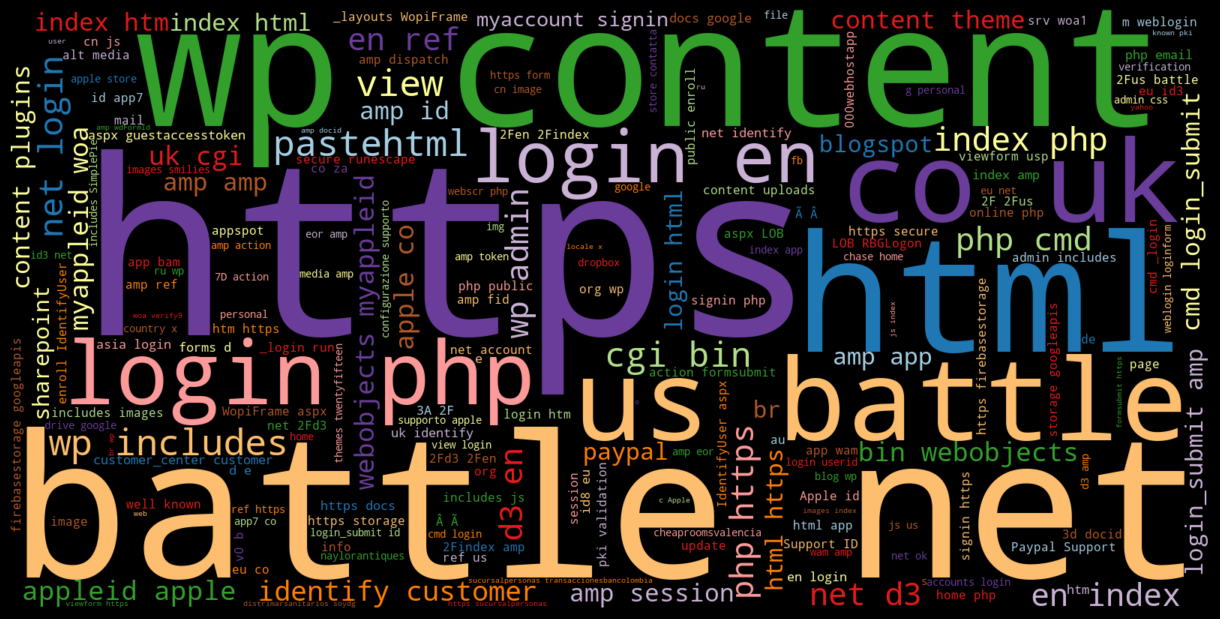

In [12]:
phish_url = " ".join(i for i in df_phish.url)
wordcloud = WordCloud(width=1600, height=800,colormap='Paired').generate(phish_url)
plt.figure(figsize=(12,14),facecolor='k')
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

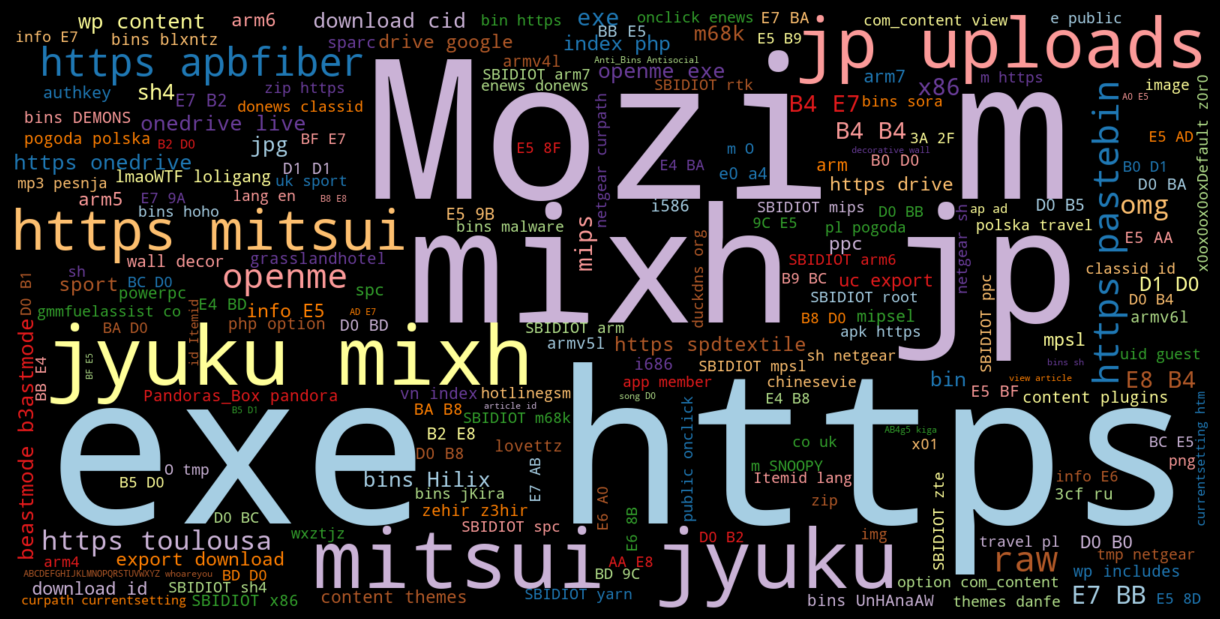

In [13]:
malware_url = " ".join(i for i in df_malware.url)
wordcloud = WordCloud(width=1600, height=800,colormap='Paired').generate(malware_url)
plt.figure( figsize=(12,14),facecolor='k')
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

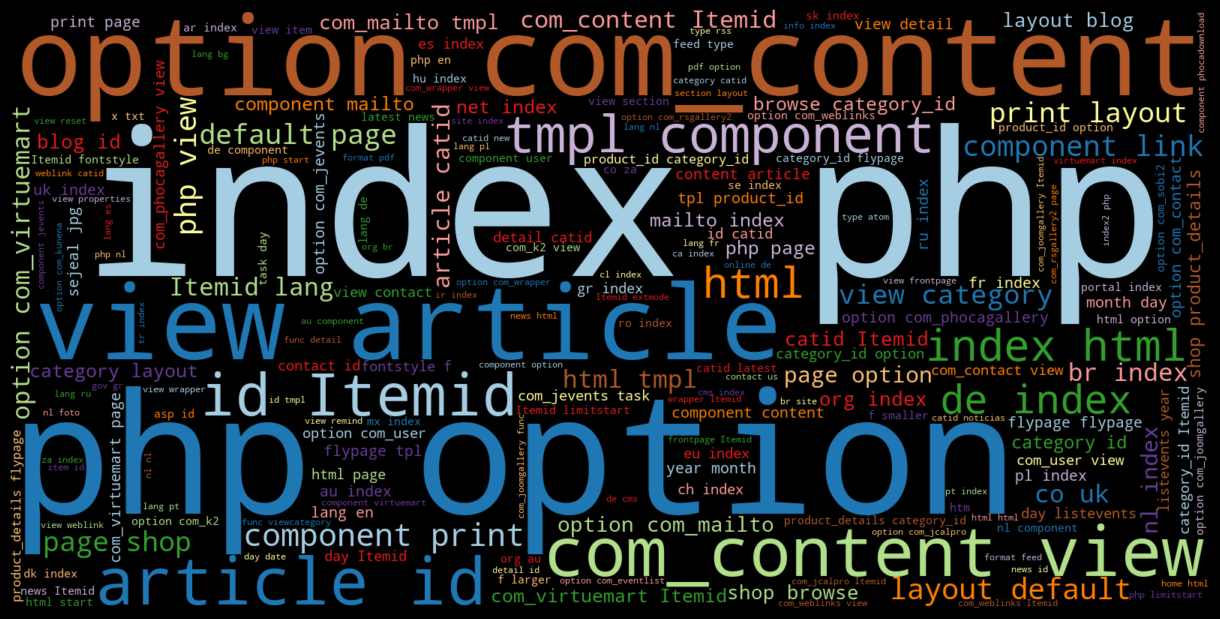

In [14]:
deface_url = " ".join(i for i in df_deface.url)
wordcloud = WordCloud(width=1600, height=800,colormap='Paired').generate(deface_url)
plt.figure( figsize=(12,14),facecolor='k')
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()


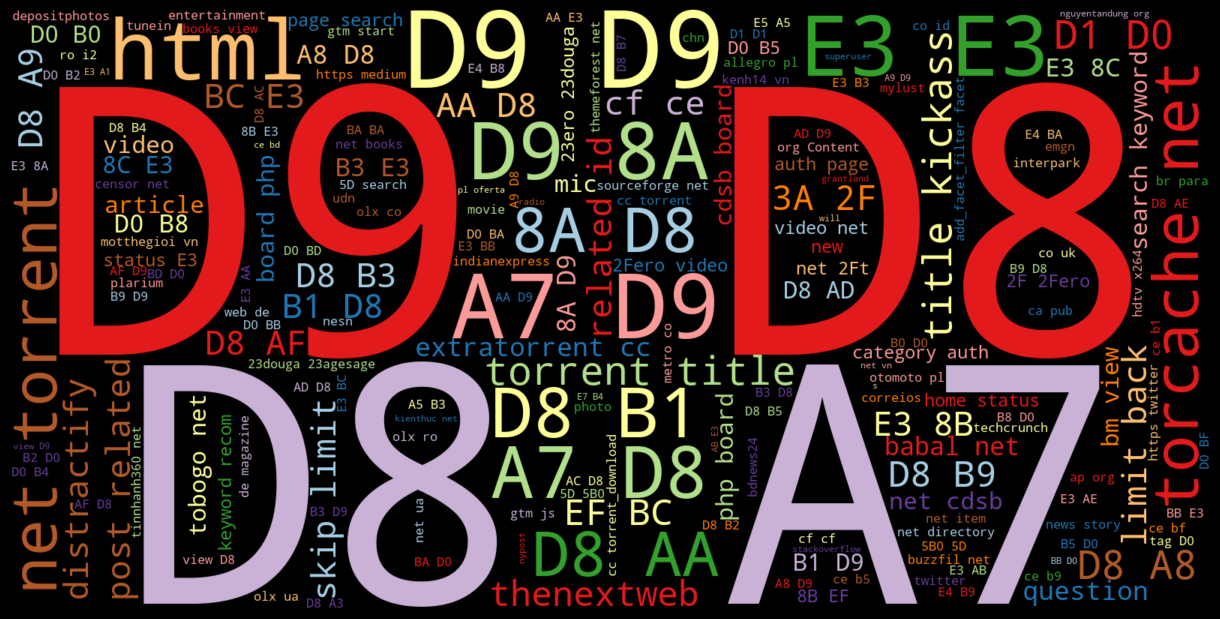

In [15]:
benign_url = " ".join(i for i in df_benign.url)
wordcloud = WordCloud(width=1600, height=800,colormap='Paired').generate(benign_url)
plt.figure( figsize=(12,14),facecolor='k')
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

-------------------------------------------------

------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

**URL Length Analysis**

In [16]:
# import matplotlib.pyplot as plt
# import seaborn as sns

# # ➤ Step 1: Compute URL length if not already done
# df['url_length'] = df['url'].apply(lambda x: len(str(x)))  # Convert each URL to string and compute its length

# # ➤ Step 2: Set up the overall figure and plot style
# plt.figure(figsize=(12,6))  # Initialize figure size
# sns.set(style="whitegrid")  # Apply clean white grid background

# # ➤ Step 3: Generate smoothed KDE plot to show distribution of URL lengths per URL type
# sns.kdeplot(
#     data=df,
#     x='url_length',
#     hue='type',             # Use URL class/type (e.g., phishing, benign, etc.) as hue
#     fill=True,              # Fill area under the curve for better visibility
#     common_norm=False,      # Don't normalize across groups — each class retains its own density
#     alpha=0.4,              # Transparency for overlay clarity
#     palette='Set2'          # Visually distinct but pastel color palette
# )

# # ➤ Step 4: Configure labels and plot presentation
# plt.title("📏 Smoothed Density of URL Lengths by Type", fontsize=14)
# plt.xlabel("URL Length", fontsize=12)
# plt.ylabel("Density", fontsize=12)
# plt.xlim(0, 300)  # Limit x-axis to the most informative range (optional for clarity)
# plt.grid(True, linestyle='--', alpha=0.5)
# plt.tight_layout()
# plt.show()


**Insights:**

- Malicious URLs (especially phishing/malware) are often longer.

- Phishing URLs often include query strings or subfolders to mimic trusted paths.

------------------------------------------------------------------------------------------------------

**Character Composition Analysis**

In [17]:
# # import string

# # # Special characters count
# # def count_special_chars(url):
# #     return sum(1 for char in url if char in string.punctuation)

# # df['special_char_count'] = df['url'].apply(count_special_chars)

# # plt.figure(figsize=(10,5))
# # sns.boxplot(data=df, x='type', y='special_char_count', palette='pastel')
# # plt.title('Special Character Count by URL Type')
# # plt.show()

# import string
# import matplotlib.pyplot as plt
# import seaborn as sns

# # Special character count function (already correct)
# def count_special_chars(url):
#     return sum(1 for char in url if char in string.punctuation)

# # Apply and store
# df['special_char_count'] = df['url'].apply(count_special_chars)

# # Create improved boxplot
# plt.figure(figsize=(12, 6))
# sns.set(style="whitegrid")

# # Optional: apply log scale to reduce skew
# sns.boxplot(data=df, x='type', y='special_char_count', palette='Set2', showfliers=False)

# # Overlay stripplot for clarity
# sns.stripplot(data=df, x='type', y='special_char_count', color='gray', size=1, jitter=True, alpha=0.3)

# # Aesthetics
# plt.yscale("log")  # Use log scale to compress extreme values
# plt.title('🔍 Special Character Count by URL Type', fontsize=14)
# plt.xlabel('URL Type', fontsize=12)
# plt.ylabel('Special Char Count (Log Scale)', fontsize=12)
# plt.xticks(rotation=15)
# plt.tight_layout()
# plt.show()


In [18]:
# # mean or median
# import numpy as np
# df.groupby('type')['special_char_count'].median()


**Observation:**

Malware and phishing URLs often contain more special characters (e.g., @, ?, =, %) to manipulate parameters or confuse users.

In [19]:
df.head()

url        type  is_broken
0  http://www.garage-pirenne.be/index.php?option=...  defacement      False
1  http://adventure-nicaragua.net/index.php?optio...  defacement      False
2  http://buzzfil.net/m/show-art/ils-etaient-loin...      benign      False
3       http://www.pashminaonline.com/pure-pashminas  defacement      False
4  http://www.ikenmijnkunst.nl/index.php/expositi...  defacement      False

------------------------------------------------------------------------------------------------------

**Numerical Characters in URLs python**

In [20]:
# df['digit_count'] = df['url'].apply(lambda x: sum(c.isdigit() for c in x))

# plt.figure(figsize=(10,5))
# sns.violinplot(data=df, x='type', y='digit_count', palette='muted')
# plt.title('Digit Count Distribution by URL Type')
# plt.show()

**Insight:**

Digits are commonly used in malicious URLs, often in obfuscation or random string generation (e.g., free123prize.tk, verifyacc4now.com).

In [21]:
df.head()

url        type  is_broken
0  http://www.garage-pirenne.be/index.php?option=...  defacement      False
1  http://adventure-nicaragua.net/index.php?optio...  defacement      False
2  http://buzzfil.net/m/show-art/ils-etaient-loin...      benign      False
3       http://www.pashminaonline.com/pure-pashminas  defacement      False
4  http://www.ikenmijnkunst.nl/index.php/expositi...  defacement      False

------------------------------------------------------------------------------------------------------

**Top-Level Domain (TLD) Analysis**

In [22]:
# from urllib.parse import urlparse

# def get_tld(url):
#     try:
#         return urlparse(url).netloc.split('.')[-1]
#     except:
#         return ''

# df['tld'] = df['url'].apply(get_tld)
# df['tld_cleaned'] = df['tld'].replace('', 'unknown')
# df['is_tld_missing'] = df['tld'].apply(lambda x: int(x == '')) # creates a new binary feature called 'is_tld_missing' -> helps you flag malformed or suspicious URLs where TLD extraction failed


# plt.figure(figsize=(14,6))
# tld_counts = df['tld_cleaned'].value_counts().head(15)
# sns.barplot(x=tld_counts.index, y=tld_counts.values, palette='Set3')
# plt.title('Top 15 Most Common TLDs in Dataset')
# plt.ylabel("Frequency")
# plt.xlabel("Top-Level Domain (TLD)")
# plt.show()
# #

In [23]:
# df['tld'].value_counts().head(10)


**Insight:**

Malicious domains often use lesser-known or cheap TLDs like .xyz, .tk, .ga, .top.

In [24]:
df.head()

url        type  is_broken
0  http://www.garage-pirenne.be/index.php?option=...  defacement      False
1  http://adventure-nicaragua.net/index.php?optio...  defacement      False
2  http://buzzfil.net/m/show-art/ils-etaient-loin...      benign      False
3       http://www.pashminaonline.com/pure-pashminas  defacement      False
4  http://www.ikenmijnkunst.nl/index.php/expositi...  defacement      False

------------------------------------------------------------------------------------------------------

**Keyword Presence in URLs**

In [25]:
# # Check for presence of suspicious keywords
# keywords = ['login', 'secure', 'update', 'free', 'verify', 'account', 'bank']
# for kw in keywords:
#     df[f'has_{kw}'] = df['url'].str.contains(kw, case=False).astype(int)

# keyword_summary = df[[f'has_{kw}' for kw in keywords]].sum().sort_values(ascending=False)
# keyword_summary.plot(kind='bar', title='Keyword Occurrence in URLs', figsize=(10,5), color='salmon')
# plt.ylabel('Number of URLs')
# plt.show()


Considering the frequency of specific keywords in URLs, I will be including these in binary keyword indicators. These features often contribute significantly to recall for malicious classes.

**Insight:**

Phishing and defacement URLs often include words like login, secure, verify, and account to trick users.

In [26]:
df.head()

url        type  is_broken
0  http://www.garage-pirenne.be/index.php?option=...  defacement      False
1  http://adventure-nicaragua.net/index.php?optio...  defacement      False
2  http://buzzfil.net/m/show-art/ils-etaient-loin...      benign      False
3       http://www.pashminaonline.com/pure-pashminas  defacement      False
4  http://www.ikenmijnkunst.nl/index.php/expositi...  defacement      False

**Analyze Keyword Impact by Class**

In [27]:
# for col in ['has_login', 'has_free', 'has_account', 'has_secure', 'has_bank', 'has_update', 'has_verify']:
#     cross = pd.crosstab(df[col], df['type'], normalize='index') * 100
#     print(f"\nKeyword: {col}")
#     print(cross)


In [28]:
df.head()

url        type  is_broken
0  http://www.garage-pirenne.be/index.php?option=...  defacement      False
1  http://adventure-nicaragua.net/index.php?optio...  defacement      False
2  http://buzzfil.net/m/show-art/ils-etaient-loin...      benign      False
3       http://www.pashminaonline.com/pure-pashminas  defacement      False
4  http://www.ikenmijnkunst.nl/index.php/expositi...  defacement      False

------------------------------------------------------------------------------------------------------

**Correlation Heatmap of Engineered Features**

In [29]:
# features = ['url_length', 'special_char_count', 'digit_count'] + [f'has_{kw}' for kw in keywords]

# df['type_encoded'] = df['type'].astype('category').cat.codes
# corr = df[features + ['type_encoded']].corr()

# plt.figure(figsize=(10,7))
# sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
# plt.title('Correlation Heatmap of URL Features')
# plt.show()

**Interpretation:**

Strong correlation between label and features like special characters, digit count, and phishing-related keywords.

In [30]:
df.head()

url        type  is_broken
0  http://www.garage-pirenne.be/index.php?option=...  defacement      False
1  http://adventure-nicaragua.net/index.php?optio...  defacement      False
2  http://buzzfil.net/m/show-art/ils-etaient-loin...      benign      False
3       http://www.pashminaonline.com/pure-pashminas  defacement      False
4  http://www.ikenmijnkunst.nl/index.php/expositi...  defacement      False

------------------------------------------------------------------------------------------------------

**Final Dataset Shape and Class Ratio**

In [31]:
from sklearn.utils import compute_class_weight
import numpy as np

classes = np.unique(df['type'])
weights = compute_class_weight(class_weight='balanced', classes=classes, y=df['type'])
dict(zip(classes, weights))

{'benign': 1.2575329300695348,
 'defacement': 0.46679187476392325,
 'malware': 1.9830176064185425,
 'phishing': 1.791383128649084}

**Takeaway:**

This ratio can be used to set class weights for models like XGBoost, RandomForest, or deep networks, ensuring fair learning across imbalanced labels.

In [32]:
df.head()

url        type  is_broken
0  http://www.garage-pirenne.be/index.php?option=...  defacement      False
1  http://adventure-nicaragua.net/index.php?optio...  defacement      False
2  http://buzzfil.net/m/show-art/ils-etaient-loin...      benign      False
3       http://www.pashminaonline.com/pure-pashminas  defacement      False
4  http://www.ikenmijnkunst.nl/index.php/expositi...  defacement      False

------------------------------------------------------------------------------------------------------

# Data Pre-processing

The process of cleaning and preparing raw data so it can be used by a machine learning model.

**Number of Slashed in the URL**

In [33]:
def count_slashes(url):
    try:
        return url.count('/')
    except:
        return 0


Measures the URL depth
-> more slashes may indicate suspicious nesting

**Number of Parameters in the Query**

In [34]:
from urllib.parse import urlparse

def count_query_parameters(url):
    try:
        query = urlparse(url).query
        if not query:
            return 0
        return query.count('=')  # Each key=value pair has an '='
    except:
        return 0


Captures how many parameters are passed -> abnormal counts can signal phising

**Length of the URL**

In [35]:
def url_length(url):
    try:
        return len(url)
    except:
        return 0


Longer URLs are often used to obfuscate malicious intent

In [36]:
df.head()

url        type  is_broken
0  http://www.garage-pirenne.be/index.php?option=...  defacement      False
1  http://adventure-nicaragua.net/index.php?optio...  defacement      False
2  http://buzzfil.net/m/show-art/ils-etaient-loin...      benign      False
3       http://www.pashminaonline.com/pure-pashminas  defacement      False
4  http://www.ikenmijnkunst.nl/index.php/expositi...  defacement      False

In [37]:
# Number of columns
num_columns = df.shape[1]

# Names of columns
column_names = df.columns.tolist()

print(f"✅ Number of columns: {num_columns}")
print("✅ Column names:")
print(column_names)


✅ Number of columns: 3
✅ Column names:
['url', 'type', 'is_broken']


**Label Encoding**

In [38]:
df['label'] = df['type'].apply(lambda x: 0 if x == 'benign' else 1)

print(df.head())

                                                 url        type  is_broken  \
0  http://www.garage-pirenne.be/index.php?option=...  defacement      False   
1  http://adventure-nicaragua.net/index.php?optio...  defacement      False   
2  http://buzzfil.net/m/show-art/ils-etaient-loin...      benign      False   
3       http://www.pashminaonline.com/pure-pashminas  defacement      False   
4  http://www.ikenmijnkunst.nl/index.php/expositi...  defacement      False   

   label  
0      1  
1      1  
2      0  
3      1  
4      1  


- Most machine learning algorithms only accept numerical input
- Label encoding allows for a fast, memory-efficient way to transform the target labels into a format usuable by classifiers

# Train-Test Split

In [39]:
# Save 'url' and 'label' separately
urls = df['url']
labels = df['label']

# Save 'type' separately for later plotting
types = df['type']   

# Define feature columns 
feature_columns = df.drop(columns=['label', 'url', 'type']).columns

# Define X and y
X = df[feature_columns]
y = labels

# Stratified Split
from sklearn.model_selection import StratifiedShuffleSplit
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

for train_index, test_index in sss.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    url_train, url_test = urls.iloc[train_index], urls.iloc[test_index]
    type_train, type_test = types.iloc[train_index], types.iloc[test_index] 


Why did i split the data before feature engineering?
- Prevents data leakge
    - Ensures that information from the test set does not influence feature engineering OR scaling
- Maintains Model Integrity
    - unseen data trule must remain unseen (real-world scenario)
- Fair Evaluation
    - ensures that feature stats (e.g mean, variance) are only learned from the training set

Why did I use Stratified Split?

- It helps me ensure that the class distribution in my training and test sets is the same as in the original dataset
- It prevents the model from being biased due to missing minority classes in the test set

Con:
- It helps to keep the class distribution the  same in train/test
- But, it does not solve the imbalance inside the training set

In [40]:
print(X_train.head()) 
print(X_test.head())  

        is_broken
22356       False
83578       False
124563      False
87813       False
74124       False
        is_broken
44838       False
173377      False
61702       False
66517       False
121510      False


In [41]:
print(y_train.head())
print(y_test.head())

22356     1
83578     1
124563    0
87813     1
74124     1
Name: label, dtype: int64
44838     0
173377    1
61702     1
66517     1
121510    0
Name: label, dtype: int64


In [42]:
print(y_train.value_counts(normalize=True) * 100)
print(y_test.value_counts(normalize=True) * 100)


label
1    80.119974
0    19.880026
Name: proportion, dtype: float64
label
1    80.119128
0    19.880872
Name: proportion, dtype: float64


# Feature Engineering

The process of creating new features or modifying existing ones to improve the performance of a machine learning model

**Label Distribution**

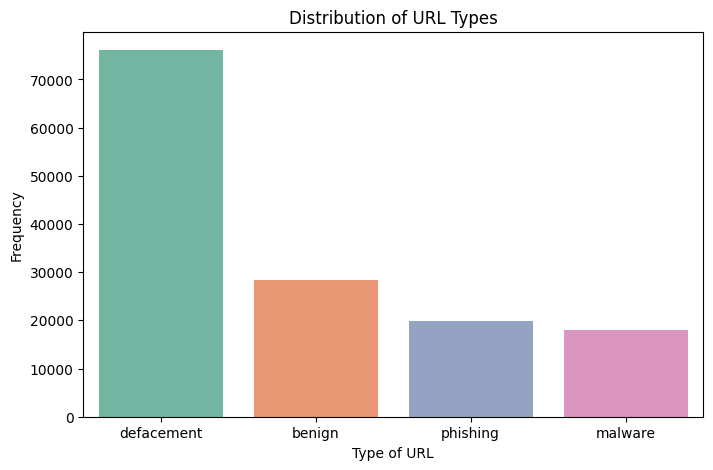

type
defacement    53.457335
benign        19.880026
phishing      13.990897
malware       12.671743
Name: proportion, dtype: float64

In [43]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8,5))
sns.countplot(x=type_train, order=type_train.value_counts().index, palette='Set2')
plt.title('Distribution of URL Types')
plt.xlabel('Type of URL')
plt.ylabel('Frequency')
plt.show()

# for percentages
type_train.value_counts(normalize=True) * 100


In [44]:
# frequency of benign, phishing, defacement, malware
url_counts = df['type'].value_counts()

print(url_counts)

type
defacement    95308
benign        35378
phishing      24835
malware       22435
Name: count, dtype: int64


**Observation:**

Class imbalance is clearly visible.

Around 50–60% are benign; phishing is the most common malicious type.

Class imbalance should be handled in model training (e.g., stratified sampling, class weights).

Solution:

- Using Stratified Splitting

- Apply Class Weighting

- Resampling techniques

**URL Length Analysis**

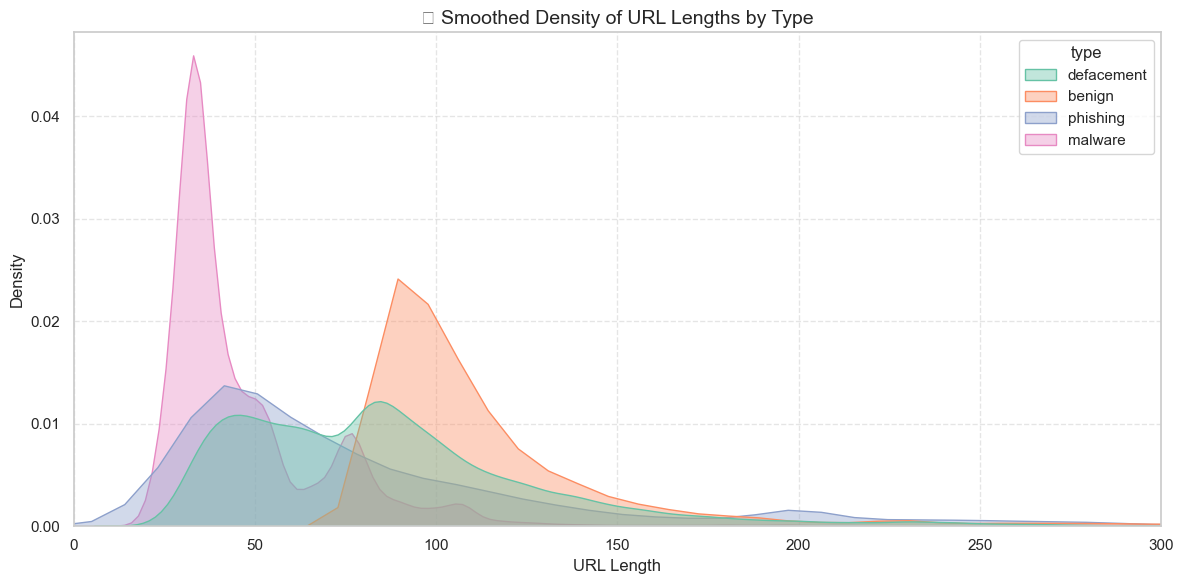

In [45]:
import matplotlib.pyplot as plt
import seaborn as sns

# Computes URL length and adds it to X_train
X_train['url_length'] = url_train.apply(lambda x: len(str(x)))  

# url_length to X_test
X_test['url_length'] = url_test.apply(lambda x: len(str(x)))  

# Setting up the overall figure and plot style
plt.figure(figsize=(12,6))
sns.set(style="whitegrid")  

# Generates smoothed KDE plot to show distribution of URL lengths per URL type
sns.kdeplot(
    data=pd.concat([X_train[['url_length']], type_train], axis=1), 
    x='url_length',
    hue='type',             
    fill=True,              
    common_norm=False,      
    alpha=0.4,              
    palette='Set2'          
)

# Configure labels and plot presentation
plt.title("📏 Smoothed Density of URL Lengths by Type", fontsize=14)
plt.xlabel("URL Length", fontsize=12)
plt.ylabel("Density", fontsize=12)
plt.xlim(0, 300) 
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


Observation:

- Bengin URLs tend to be longer, peaking around 100 characters
- Malware URLs have a sharp peak at 30-40 characters, showing much shorter lengths
- Phishing and Defacement URLs have broader distributions, generally shorter than benign URLs but longer than malware URLs
 
url_length feature helps to:
- capture structural patterns
- simple yet informative -> provides quick heuristics to distinguish between benign and malicious behaviors without needing deep parsing
- helps the model generalize -> model can learn that extremely short or long URLs may more likely be malicious or benign

**Character Composition**

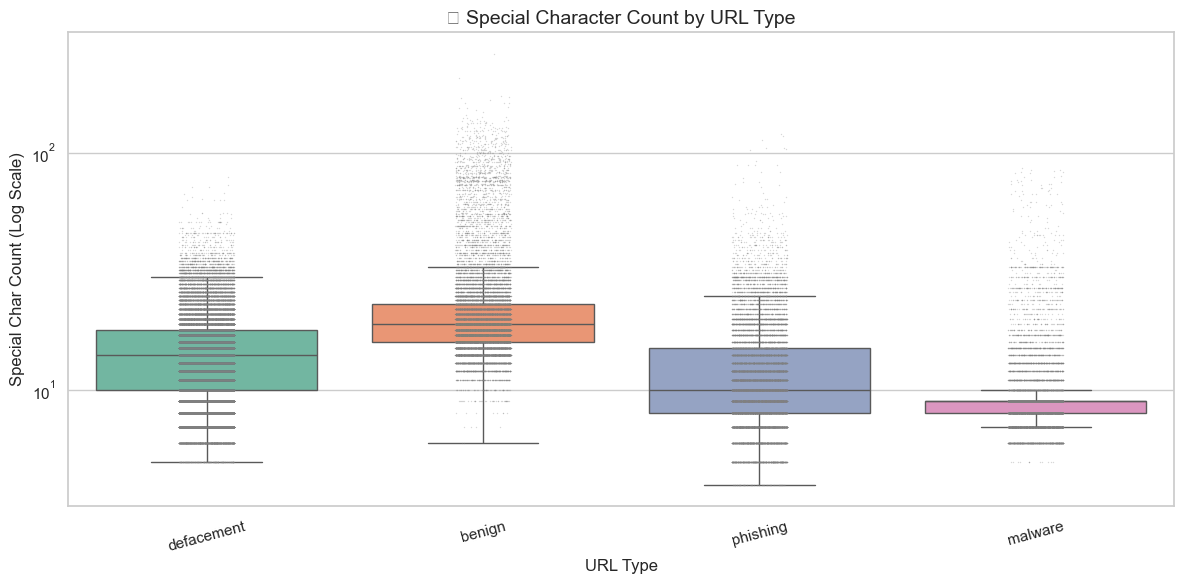

In [46]:
import string
import matplotlib.pyplot as plt
import seaborn as sns

# Special character count function
def count_special_chars(url):
    return sum(1 for char in url if char in string.punctuation)

# pecial_char_count to X_train
X_train['special_char_count'] = url_train.apply(count_special_chars)

# special_char_count to X_test
X_test['special_char_count'] = url_test.apply(count_special_chars)

# boxplot (Train Set Only)
plt.figure(figsize=(12, 6))
sns.set(style="whitegrid")

# Plot using type_train + X_train
sns.boxplot(
    data=pd.concat([X_train[['special_char_count']], type_train], axis=1),
    x='type',
    y='special_char_count',
    palette='Set2',
    showfliers=False
)

# Overlay stripplot for clarity
sns.stripplot(
    data=pd.concat([X_train[['special_char_count']], type_train], axis=1),
    x='type',
    y='special_char_count',
    color='gray',
    size=1,
    jitter=True,
    alpha=0.3
)

# Aesthetics
plt.yscale("log")  
plt.title('🔍 Special Character Count by URL Type', fontsize=14)
plt.xlabel('URL Type', fontsize=12)
plt.ylabel('Special Char Count (Log Scale)', fontsize=12)
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()


Observation:
- Benign URLs have the highest median special character count
- Malware URLs show the lowest median special character count -> meaning they tend to be simipler
- Phishing and Defacement URLs are somewhere in between, but skewed toward fewer special characters.


special_char_count helps to:

- capture obfuscation tactic -> malicious URLs often inject special characters to confuse the model and bypass
- signal of complexity -> higher/unusual usage of special characters counts can indicate attempts to mask malicious intent
- boosts model discrimination -> model distinguishes suspicious, noisy URLs from normal, benign URLs

**Numerical Character in URLs**

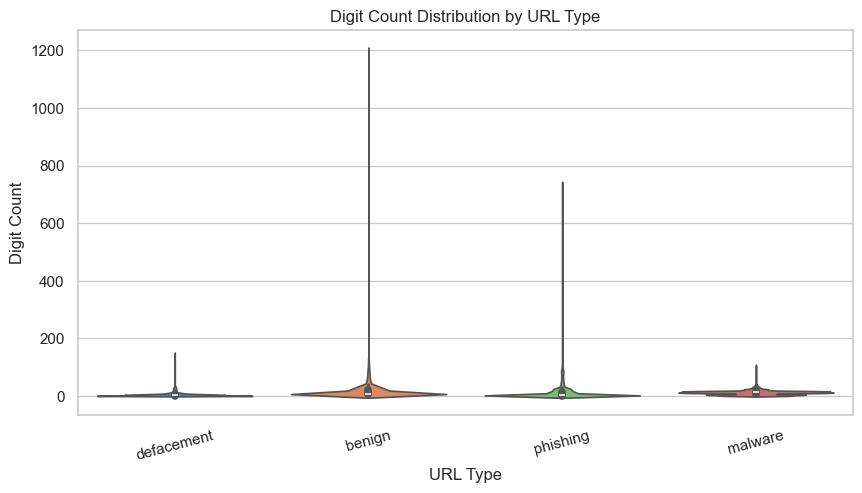

In [47]:
# digit_count feature into X_train
X_train['digit_count'] = url_train.apply(lambda x: sum(c.isdigit() for c in x))

# digit_count feature into X_test
X_test['digit_count'] = url_test.apply(lambda x: sum(c.isdigit() for c in x))

# Plotting (Train Set)
plt.figure(figsize=(10,5))
sns.violinplot(
    data=pd.concat([X_train[['digit_count']], type_train], axis=1),
    x='type',
    y='digit_count',
    palette='muted'
)
plt.title('Digit Count Distribution by URL Type')
plt.xlabel('URL Type')
plt.ylabel('Digit Count')
plt.xticks(rotation=15)
plt.show()


Observation:
- Benign URLs have a higher digit count on average compared to malicious ones
- Malware and defacement URLs show the lowest digit density.
- Phishing URLs fall in between but are generally closer to malware in digit distribution.

digit_count helps to:

- Detects Evasion Techniques -> Malicious URLs often use random digits to generate unique URLs
- Indicates Automation -> high count of digits could suggest the idea that the URL is generated by bot or is malicious
  
- Enhances Pattern Recognition -> Helps the model learn that benign URLs typically have fewer digits in comparison to malicious ones 

**Top-Level Domain (TLD) Analysis**

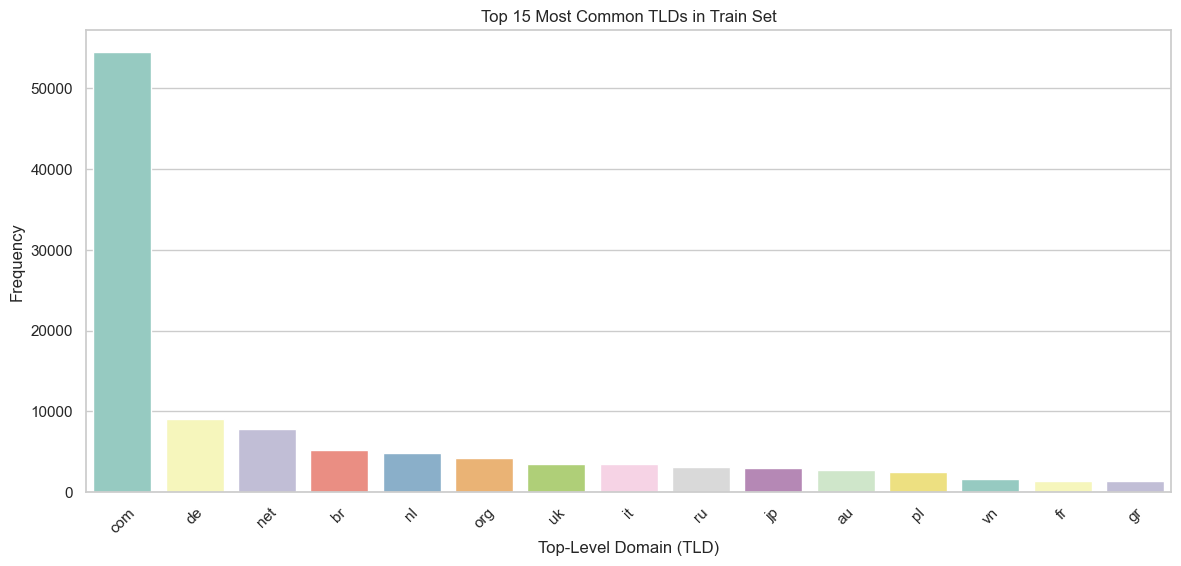

In [48]:
from urllib.parse import urlparse

def get_tld(url):
    try:
        return urlparse(url).netloc.split('.')[-1]
    except:
        return ''

# Add TLD features into X_train
X_train['tld'] = url_train.apply(get_tld)
X_train['tld_cleaned'] = X_train['tld'].replace('', 'unknown')
X_train['is_tld_missing'] = X_train['tld'].apply(lambda x: int(x == ''))

# Add TLD features into X_test
X_test['tld'] = url_test.apply(get_tld)
X_test['tld_cleaned'] = X_test['tld'].replace('', 'unknown')
X_test['is_tld_missing'] = X_test['tld'].apply(lambda x: int(x == ''))

# Plotting (Train Set)
plt.figure(figsize=(14,6))
tld_counts = X_train['tld_cleaned'].value_counts().head(15)
sns.barplot(x=tld_counts.index, y=tld_counts.values, palette='Set3')
plt.title('Top 15 Most Common TLDs in Train Set')
plt.ylabel("Frequency")
plt.xlabel("Top-Level Domain (TLD)")
plt.xticks(rotation=45)
plt.show()


tld:
- it extracts the Top-Level Domain (TLD) from the URL (for e.g. .com, .net and etc)
- this is important because some TLDs are more commonly abused by attackers (e.g .tk, .xyz)

tld_cleaned:
- replaces missing or empty TLDs with 'unknown' -> ensuring robutness during training, avoiding null errors

is_tld_missing:
- flags URLs without a valid TLD - this is because missing TLDs can be a red flag for suspicious or malformed URLs

**Keyword Presence in URLs**

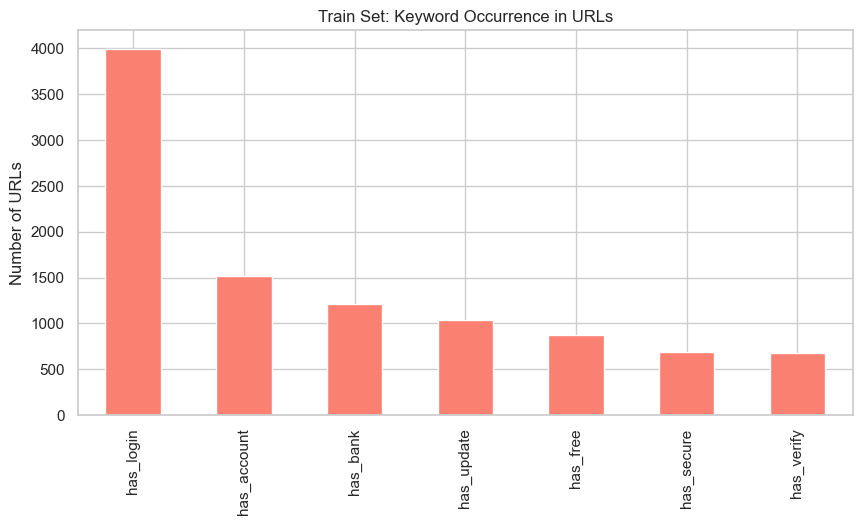

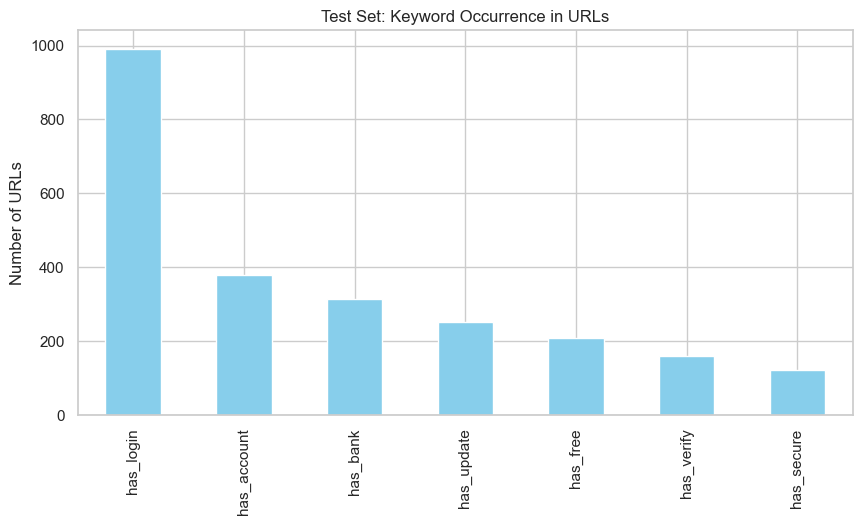

In [49]:
# Checks presence of suspicious keywords
keywords = ['login', 'secure', 'update', 'free', 'verify', 'account', 'bank']

# keyword features for X_train
for kw in keywords:
    X_train[f'has_{kw}'] = url_train.str.contains(kw, case=False).astype(int)

# keyword features for X_test
for kw in keywords:
    X_test[f'has_{kw}'] = url_test.str.contains(kw, case=False).astype(int)

# Plotting (Train Set)
keyword_summary_train = X_train[[f'has_{kw}' for kw in keywords]].sum().sort_values(ascending=False)
keyword_summary_train.plot(
    kind='bar',
    title='Train Set: Keyword Occurrence in URLs',
    figsize=(10,5),
    color='salmon'
)
plt.ylabel('Number of URLs')
plt.show()

# Plotting (Test Set)
keyword_summary_test = X_test[[f'has_{kw}' for kw in keywords]].sum().sort_values(ascending=False)
keyword_summary_test.plot(
    kind='bar',
    title='Test Set: Keyword Occurrence in URLs',
    figsize=(10,5),
    color='skyblue'
)
plt.ylabel('Number of URLs')
plt.show()


"has_<.keyword>" feature:
- has_<.keyword> flags whether specific suspicious words (such as login, bank, account) appear in the URL
- These keywords are commonly used in phishing and malicious URLs to trick users into trusting fake sites

**Analyze Keyword Impact by Class**

In [50]:
keywords_cols = ['has_login', 'has_free', 'has_account', 'has_secure', 'has_bank', 'has_update', 'has_verify']

# Crosstab for train set
for col in keywords_cols:
    cross = pd.crosstab(X_train[col], type_train, normalize='index') * 100
    print(f"\nTrain Set - Keyword: {col}")
    print(cross)

# Crosstab for test set
for col in keywords_cols:
    cross = pd.crosstab(X_test[col], type_test, normalize='index') * 100
    print(f"\nTest Set - Keyword: {col}")
    print(cross)



Train Set - Keyword: has_login
type          benign  defacement    malware   phishing
has_login                                             
0          20.245434   54.821598  13.009605  11.923363
1           7.230423    6.229672   0.975732  85.564173

Train Set - Keyword: has_free
type         benign  defacement    malware   phishing
has_free                                             
0         19.667103   53.631834  12.736332  13.964731
1         54.152446   25.369738   2.275313  18.202503

Train Set - Keyword: has_account
type            benign  defacement    malware   phishing
has_account                                             
0            19.991196   53.977507  12.789509  13.241789
1             9.592641    5.321945   1.773982  83.311432

Train Set - Keyword: has_secure
type           benign  defacement    malware   phishing
has_secure                                             
0           19.959767   53.716605  12.700900  13.622728
1            3.483309    0.145138   6.

Analyzing keyword imapct helps by class helps me to:
- analyse the relationship between the presence of specific keywords (has_login, has_free, etc) and the URL type
- the crosstab give me the percentage distributions which helps in verifying if certain keywords are strongly associated with malicious URLs

**Correlation Heatmap of Engineered features**

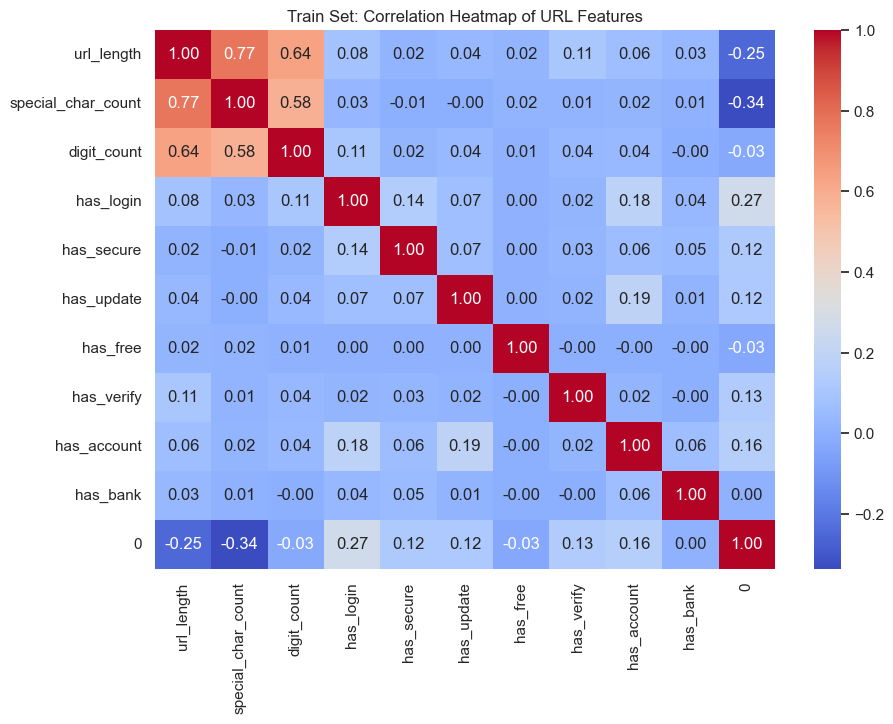

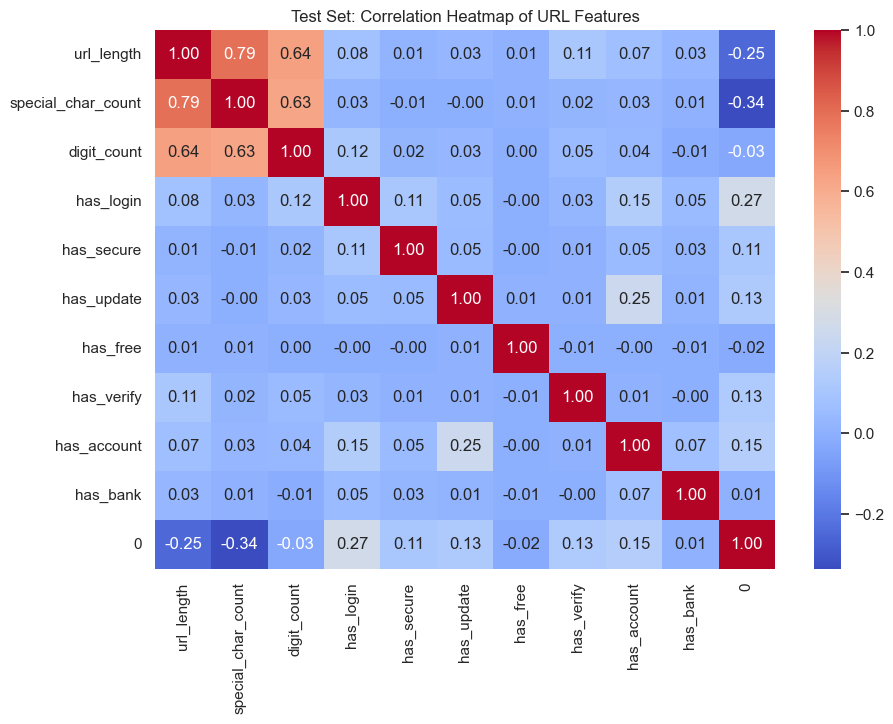

In [51]:
# Feature list
features = ['url_length', 'special_char_count', 'digit_count'] + [f'has_{kw}' for kw in keywords]

# Encode type labels (categorical to numeric)
type_train_encoded = type_train.astype('category').cat.codes
type_test_encoded = type_test.astype('category').cat.codes  # NEW for test set

# Correlation calculation for train
corr_train = pd.concat([X_train[features], type_train_encoded], axis=1).corr()

# Correlation calculation for test
corr_test = pd.concat([X_test[features], type_test_encoded], axis=1).corr()

# Plotting Train Correlation
plt.figure(figsize=(10,7))
sns.heatmap(corr_train, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Train Set: Correlation Heatmap of URL Features')
plt.show()

# Plotting Test Correlation
plt.figure(figsize=(10,7))
sns.heatmap(corr_test, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Test Set: Correlation Heatmap of URL Features')
plt.show()


Running the code on Correlation Heatmap of Engineered features helps me to:
- Calculate the Pearson correlation between features and the label for both training and test sets.
- Visualize the strength and direction of relationships using correlation heatmap.                           

**Lexical Feature Extraction**

In [52]:
# suspicious keywords
suspicious_keywords = ['login', 'signin', 'verify', 'update', 'banking', 'account', 'secure', 'ebay', 'paypal']

# feature extraction
def extract_features(url):
    features = {}

    # Total length of the URL
    features['url_length'] = len(url)

    # Number of digits in the URL
    features['num_digits'] = sum(c.isdigit() for c in url)

    # Number of special characters (punctuation) in the URL
    features['num_special_chars'] = sum(c in string.punctuation for c in url)

    # Number of subdomains
    features['num_subdomains'] = url.count('.') - 1

    # Whether the URL contains an IP address instead of a domain
    features['has_ip'] = 1 if re.search(r'\d+\.\d+\.\d+\.\d+', url) else 0

    # Whether the URL uses HTTPS
    features['has_https'] = int('https' in url.lower())

    # Number of query parameters
    features['num_params'] = url.count('?')

    # Number of URL fragments
    features['num_fragments'] = url.count('#')

    # Total number of slashes in the URL
    features['num_slashes'] = url.count('/')

    # Whether the URL contains any suspicious keywords
    features['has_suspicious_words'] = int(any(word in url.lower() for word in suspicious_keywords))

    # Length of the top-level domain
    tld = url.split('.')[-1]
    features['tld_length'] = len(tld)

    # Whether the TLD is a common one
    features['is_common_tld'] = int(tld in ['com', 'org', 'net', 'edu', 'gov'])

    # Whether the URL contains hexadecimal encoding
    features['has_hex'] = int(bool(re.search(r'%[0-9a-fA-F]{2}', url)))

    # Whether the URL has repeated characters
    features['repeated_chars'] = int(bool(re.search(r'(.)\1{3,}', url)))

    return pd.Series(features)

# feature extraction after splitting
features_train = url_train.apply(extract_features)
features_test = url_test.apply(extract_features)

# engineered features into X_train and X_test
X_train = pd.concat([X_train.reset_index(drop=True), features_train.reset_index(drop=True)], axis=1)
X_test = pd.concat([X_test.reset_index(drop=True), features_test.reset_index(drop=True)], axis=1)


- Lexical Feature Extraction helped me to capture the syntactic complexity of a URL.
- Lexical patterns are **content-independent** and don't require web access
  - This makes them ideal for fast, offline detection

**Primary Domain Extraction**

In [53]:
def extract_pri_domain(url):
    try:
        res = get_tld(url, as_object=True, fail_silently=False, fix_protocol=True)  # fix_protocol tries to automatically fix the URL when missing http:// or https://
        return res.parsed_url.netloc
    except:
        return None

# feature extraction after splitting
pri_domain_train = url_train.apply(extract_pri_domain)
pri_domain_test = url_test.apply(extract_pri_domain)

# engineered feature into X_train and X_test
X_train = pd.concat([X_train.reset_index(drop=True), pri_domain_train.rename('pri_domain').reset_index(drop=True)], axis=1)
X_test = pd.concat([X_test.reset_index(drop=True), pri_domain_test.rename('pri_domain').reset_index(drop=True)], axis=1)


- Attackers often use misleading subdomains 
- Analysing the primary domains helps identify spoofed or uncommon doamins
- **Primary Domain Extraction** can be paired with TLD analysis

In [54]:
df.head()

url        type  is_broken  \
0  http://www.garage-pirenne.be/index.php?option=...  defacement      False   
1  http://adventure-nicaragua.net/index.php?optio...  defacement      False   
2  http://buzzfil.net/m/show-art/ils-etaient-loin...      benign      False   
3       http://www.pashminaonline.com/pure-pashminas  defacement      False   
4  http://www.ikenmijnkunst.nl/index.php/expositi...  defacement      False   

   label  
0      1  
1      1  
2      0  
3      1  
4      1

**Shortening Service Check**

In [55]:
# feature extraction after splitting
letters_count_train = url_train.apply(lambda x: sum(char.isalpha() for char in x))
digits_count_train = url_train.apply(lambda x: sum(char.isdigit() for char in x))
special_chars_count_train = url_train.apply(lambda x: sum(char in string.punctuation for char in x))

letters_count_test = url_test.apply(lambda x: sum(char.isalpha() for char in x))
digits_count_test = url_test.apply(lambda x: sum(char.isdigit() for char in x))
special_chars_count_test = url_test.apply(lambda x: sum(char in string.punctuation for char in x))

# new features into X_train and X_test
X_train = pd.concat([
    X_train.reset_index(drop=True),
    letters_count_train.rename('letters_count').reset_index(drop=True),
    digits_count_train.rename('digits_count').reset_index(drop=True),
    special_chars_count_train.rename('special_chars_count').reset_index(drop=True)
], axis=1)

X_test = pd.concat([
    X_test.reset_index(drop=True),
    letters_count_test.rename('letters_count').reset_index(drop=True),
    digits_count_test.rename('digits_count').reset_index(drop=True),
    special_chars_count_test.rename('special_chars_count').reset_index(drop=True)
], axis=1)


- Malicious URLs often embed random characters to evade detection
- Which is why, high counts of digits or special characters in a URL suggest obfuscation or auto-generated URLs
- **Character Composition Features** helps me for my model training by capturing anomalous character usage statistically 

**Character Composition Features**

In [56]:
def has_shortening_service(url):
    pattern = re.compile(r'https?://(?:www\.)?(?:\w+\.)*(\w+)\.\w+')
    match = pattern.search(url)
    if match:
        domain = match.group(1).lower()
        shorteners = set(['bit', 'goo', 'tinyurl', 'ow', 't', 'is', 'cli', 'yfrog', 'su', 'snipurl', 'lnkd', 'adf', 'bitly', 'cutt', 'qr', '1url'])
        return int(domain in shorteners)
    return 0

# Applied to url_train and url_test
shortened_train = url_train.apply(has_shortening_service)
shortened_test = url_test.apply(has_shortening_service)

# new feature into X_train and X_test
X_train = pd.concat([X_train.reset_index(drop=True), shortened_train.rename('shortened').reset_index(drop=True)], axis=1)
X_test = pd.concat([X_test.reset_index(drop=True), shortened_test.rename('shortened').reset_index(drop=True)], axis=1)


- Shorteners are frequently used to hide the true destination of malicious URLs
- **Character Composition Features** feature helps me to flag indirect redirection.
- It is a well-known tactic in phishing and malware distribution.

**Abnormal URL Structure**

In [57]:
def abnormal_url(url):
    parsed = urlparse(url)
    return int(parsed.netloc in url)

# Applied to url_train and url_test
abnormal_url_train = url_train.apply(abnormal_url)
abnormal_url_test = url_test.apply(abnormal_url)

# new feature into X_train and X_test
X_train = pd.concat([X_train.reset_index(drop=True), abnormal_url_train.rename('abnormal_url').reset_index(drop=True)], axis=1)
X_test = pd.concat([X_test.reset_index(drop=True), abnormal_url_test.rename('abnormal_url').reset_index(drop=True)], axis=1)


- Malicious URLs inject parameters or paths unnaturally.
- Structural anomalies can indicate tampering or payload injection.

**Secure HTTP (HTTPS)**

In [58]:
# Applied to url_train and url_test
secure_http_train = url_train.apply(lambda x: int(urlparse(x).scheme == 'https'))
secure_http_test = url_test.apply(lambda x: int(urlparse(x).scheme == 'https'))

# new feature into X_train and X_test
X_train = pd.concat([X_train.reset_index(drop=True), secure_http_train.rename('secure_http').reset_index(drop=True)], axis=1)
X_test = pd.concat([X_test.reset_index(drop=True), secure_http_test.rename('secure_http').reset_index(drop=True)], axis=1)


- Many URLs avoid HTTPS to reduce setup complexity & falsely mimic secure-looking URLs
- The presence and absence of HTTPS is a subtle yet a informative signal

**IP Address Check**

In [59]:
def have_ip_address(url):
    try:
        ip = ipaddress.ip_address(urlparse(url).hostname)
        return int(isinstance(ip, (ipaddress.IPv4Address, ipaddress.IPv6Address)))
    except:
        return 0

# Applied to url_train and url_test
have_ip_train = url_train.apply(have_ip_address)
have_ip_test = url_test.apply(have_ip_address)

# new feature into X_train and X_test
X_train = pd.concat([X_train.reset_index(drop=True), have_ip_train.rename('have_ip').reset_index(drop=True)], axis=1)
X_test = pd.concat([X_test.reset_index(drop=True), have_ip_test.rename('have_ip').reset_index(drop=True)], axis=1)


- Legitimate services almost never use raw IP addresses in user-facing links.
- URLs with IP addresses are often associated with command-and-control servers, driver-by downalods or unautheticated phising kits

In [60]:
df.head()

url        type  is_broken  \
0  http://www.garage-pirenne.be/index.php?option=...  defacement      False   
1  http://adventure-nicaragua.net/index.php?optio...  defacement      False   
2  http://buzzfil.net/m/show-art/ils-etaient-loin...      benign      False   
3       http://www.pashminaonline.com/pure-pashminas  defacement      False   
4  http://www.ikenmijnkunst.nl/index.php/expositi...  defacement      False   

   label  
0      1  
1      1  
2      0  
3      1  
4      1

In [61]:
print(X_train.columns.tolist())

['is_broken', 'url_length', 'special_char_count', 'digit_count', 'tld', 'tld_cleaned', 'is_tld_missing', 'has_login', 'has_secure', 'has_update', 'has_free', 'has_verify', 'has_account', 'has_bank', 'url_length', 'num_digits', 'num_special_chars', 'num_subdomains', 'has_ip', 'has_https', 'num_params', 'num_fragments', 'num_slashes', 'has_suspicious_words', 'tld_length', 'is_common_tld', 'has_hex', 'repeated_chars', 'pri_domain', 'letters_count', 'digits_count', 'special_chars_count', 'shortened', 'abnormal_url', 'secure_http', 'have_ip']


In [62]:
# Remove duplicate columns
X_train = X_train.loc[:, ~X_train.columns.duplicated()]
X_test = X_test.loc[:, ~X_test.columns.duplicated()]


**Binary Flags for Suspicious URL Lengths**

In [63]:
# Transforms continuous feature, url_length --> into interpretable binary signals

X_train['is_long_url'] = (X_train['url_length'].values > 100).astype(int)
X_train['is_short_url'] = (X_train['url_length'].values < 25).astype(int)

X_test['is_long_url'] = (X_test['url_length'].values > 100).astype(int)
X_test['is_short_url'] = (X_test['url_length'].values < 25).astype(int)

# Helps models (especially decision trees, random forests, XGBoost)


- Very short URLs: often shortened or minimal redirect payloads
- Very long URLs: excessive nesting or obfuscation
- Binary thresholds make it easier for tree-based models to trigger safety checks

**Handling Missing Values in Domain Features**

In [64]:
# checking how many missing values per column in X_train
missing_per_column_train = X_train.isnull().sum()
missing_per_column_train = missing_per_column_train[missing_per_column_train > 0]
print(missing_per_column_train)

# filling missing pri_domain in X_train
X_train['pri_domain'].fillna('unknown', inplace=True)

# checking how many missing values per column in X_test
missing_per_column_test = X_test.isnull().sum()
missing_per_column_test = missing_per_column_test[missing_per_column_test > 0]
print(missing_per_column_test)

# solving missing pri_domain in X_test
X_test['pri_domain'].fillna('unknown', inplace=True)


pri_domain    142364
dtype: int64
pri_domain    35592
dtype: int64


"Handling Missing Values in Domain Features" helps:

- to prevent errors during model training
- ensures no missing data is fed into the model

In [65]:
# num of unique domains in X_train
num_unique_domains_train = X_train['pri_domain'].nunique()
print(f"✅ Number of unique domains in Train Set: {num_unique_domains_train}")

# num of unique domains in X_test
num_unique_domains_test = X_test['pri_domain'].nunique()
print(f"✅ Number of unique domains in Test Set: {num_unique_domains_test}")

# total unique domains across both sets
total_unique_domains = pd.concat([X_train['pri_domain'], X_test['pri_domain']]).nunique()
print(f"✅ Total number of unique domains across Train and Test: {total_unique_domains}")


✅ Number of unique domains in Train Set: 1
✅ Number of unique domains in Test Set: 1
✅ Total number of unique domains across Train and Test: 1


- this helps me to check domain diversity in train and test sets
- ensuring model generalization across unique domains

In [66]:
# Drop 'pri_domain' column from X_train and X_test
X_train.drop(columns=['pri_domain'], inplace=True, errors='ignore')
X_test.drop(columns=['pri_domain'], inplace=True, errors='ignore')


- After extracting features and analyzing 'pri_domain', I dropped it to avoid leaking raw domain information, which could cause the model to memorize specific doamins instead of learning patterns to generalize. 

**Lexical Features**

In [68]:
lexical_features = [
    'url_length', 'num_digits', 'num_special_chars',
    'letters_count', 'digits_count', 'special_chars_count',
    'shortened', 'abnormal_url', 'secure_http', 'have_ip'
]

# selecting lexical features from X_train and X_test
train_lexical = X_train[lexical_features]
test_lexical = X_test[lexical_features]

- this selects important lexical-based features from the URLs(such as length, character counts, structure patterns)
- helping the model to capture structural differences between benign and malicious URLs for better classification performance 

In [69]:
# preview
print(train_lexical.head())

   url_length  num_digits  num_special_chars  letters_count  digits_count  \
0         103           5                 18             80             5   
1          86           6                 18             62             6   
2         115          16                 23             76            16   
3          36           0                  8             28             0   
4         145           3                 25            117             3   

   special_chars_count  shortened  abnormal_url  secure_http  have_ip  
0                   18          0             1            0        0  
1                   18          0             1            0        0  
2                   23          0             1            0        0  
3                    8          0             1            0        0  
4                   25          0             1            0        0  


**Drop Raw Text and Leakage-Prone Columns**

In [70]:
columns_to_drop = ['url', 'pri_domain', 'tld', 'tld_cleaned', 'type']

X_train.drop(columns=[col for col in columns_to_drop if col in X_train.columns], inplace=True, errors='ignore')
X_test.drop(columns=[col for col in columns_to_drop if col in X_test.columns], inplace=True, errors='ignore')


- url: Identifies the record directly — leakage risk, and can't be used directly.

- pri_domain: Could directly hint label (paypal.com vs. random junk).

- tld, tld_cleaned: edu, gov, com — leaking benign/malicious signals.

- type: Original class name (not numeric) — should not be inside features.

- label: Should only be in y_train, y_test — not in X_train, X_test.

**Add handcrafted features**

In [71]:
from urllib.parse import urlparse
import string

def extract_features(url):
    parsed = urlparse(url)
    url_lower = url.lower()

    return {
        'url_length': len(url),
        'hostname_length': len(parsed.netloc),
        'path_length': len(parsed.path),
        'num_digits': sum(c.isdigit() for c in url),
        'num_special': sum(c in string.punctuation for c in url),
        'has_https': int('https' in parsed.scheme),
        'count_dots': url.count('.'),
        'has_login': int('login' in url_lower),
        'has_free': int('free' in url_lower),
        'has_account': int('account' in url_lower),
        'has_secure': int('secure' in url_lower),
        'has_update': int('update' in url_lower),
        'has_verify': int('verify' in url_lower),
        'has_bank': int('bank' in url_lower)
    }

train_features = pd.DataFrame([extract_features(url) for url in url_train])
test_features = pd.DataFrame([extract_features(url) for url in url_test])


- Here we; extract important lexical features from each URL (such as its length, number of digits)
- The handcrafted features turn raw URL into meaningful numeric features for machine learning
- as it helps the model differentiate between malicious and benign URLs.

In [72]:
# Confirming no missing values
print(train_features.isnull().sum())

url_length         0
hostname_length    0
path_length        0
num_digits         0
num_special        0
has_https          0
count_dots         0
has_login          0
has_free           0
has_account        0
has_secure         0
has_update         0
has_verify         0
has_bank           0
dtype: int64


**Feature Scaling**

In [73]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

# fit on train_lexical and transform
train_lexical_scaled = scaler.fit_transform(train_lexical)

# Transform test_lexical 
test_lexical_scaled = scaler.transform(test_lexical)

# check the new shapes
print(f"Train lexical scaled shape: {train_lexical_scaled.shape}")
print(f"Test lexical scaled shape: {test_lexical_scaled.shape}")


Train lexical scaled shape: (142364, 10)
Test lexical scaled shape: (35592, 10)


Numeric features are normalized so they are treated equally in distance-based/gradient-based models

During model trianing, models such as logistics regression, svm, & knn; which are sensitive to feature magnitude

Scaling was not apllied to TF-IDF since it is already normalized.

**TF-IDF on Character n-grams (URL-based)**

In [74]:
from sklearn.feature_extraction.text import TfidfVectorizer

# TF-IDF Vectorizer for character n-grams
tfidf_vectorizer = TfidfVectorizer(
    analyzer='char',        
    ngram_range=(3, 5),      
    lowercase=False,         
    max_features=5000        
)

# Fit on training URLs and transform both train and test URLs
X_train_tfidf = tfidf_vectorizer.fit_transform(url_train)
X_test_tfidf = tfidf_vectorizer.transform(url_test)

print(f"TF-IDF train shape: {X_train_tfidf.shape}")
print(f"TF-IDF test shape: {X_test_tfidf.shape}")


TF-IDF train shape: (142364, 5000)
TF-IDF test shape: (35592, 5000)


The raw URL string is converted into structured numerical features that can be used by machine learning models to classify URLs as benign

- The added handcrafted features cover semantic patterns like: presence of keywords, obfuscation, URL structure
- These are transparent, rule-based features that will help with TF-IDF
- It is critical for boosting model explainability and performance in edge cases.

**TF-IDF Vectorization**

In [75]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(
    analyzer='char', 
    ngram_range=(2, 5), 
    max_features=3000, 
)
X_train_tfidf = vectorizer.fit_transform(url_train)
X_test_tfidf = vectorizer.transform(url_test)


- Raw URL is converted into numerical feature vectors by analyzing character-level patterns (n-grams of size 2 to 5).
- URLs are transformed into numbers by breaking them into character chunks for smarter pattern detection.
- Helping the model capture important structure like suspicious substrings or common patterns in phising/malicious urls

**TruncatedSVD for TF-IDF**

In [76]:
from sklearn.decomposition import TruncatedSVD

# (Dimensionality Reduction)
svd = TruncatedSVD(n_components=300, random_state=42) 
X_train_tfidf_reduced = svd.fit_transform(X_train_tfidf)
X_test_tfidf_reduced = svd.transform(X_test_tfidf)

- Capture substrings that are often used or mimicked in phishing attacks
- Character n-grams are robust to: misspellings, subdomains manipulation, and obfuscation techniques
- TF-IDF weights rare but informative patterns higher, making it ideal for detecting abnormal URL structure

**Combine TF-IDF + handcrafted**

In [77]:
from scipy.sparse import hstack
X_train_combined = hstack([X_train_tfidf, train_features])
X_test_combined = hstack([X_test_tfidf, test_features])

Semantic and Statistical representations of the URL are joined into a single training matrix

TF-IDF captures pattern structure via text statistics
Handcrafted features capture semantic knowledge and heuristics

Combining these together would give the model the best of both worlds:
- Generalization for n-grams
- Precision from domain-aware features

**Top-Level Domain (TLD) Feature Extraction & Engineering**

In [78]:
# TLD Feature Engineering
def get_tld(url):
    try:
        return urlparse(url).netloc.split('.')[-1]
    except:
        return ''

# Extract TLDs
train_tld = url_train.apply(get_tld)
test_tld = url_test.apply(get_tld)

# One-hot encode top TLDs based only on train set
top_tlds = train_tld.value_counts().nlargest(10).index

# Replace rare TLDs with 'other'
train_tld_cleaned = train_tld.apply(lambda x: x if x in top_tlds else 'other')
test_tld_cleaned = test_tld.apply(lambda x: x if x in top_tlds else 'other')

# One-hot encoding
train_tld_dummies = pd.get_dummies(train_tld_cleaned, prefix='tld')
test_tld_dummies = pd.get_dummies(test_tld_cleaned, prefix='tld')

# Suspicious TLDs
suspicious_tlds = ['xyz', 'top', 'tk', 'ml', 'ga']
train_suspicious_tld = train_tld.apply(lambda x: int(x in suspicious_tlds))
test_suspicious_tld = test_tld.apply(lambda x: int(x in suspicious_tlds))


Top-Level Domain(TLD) enhances the dataset by extracting and encoding information from the TLD of each URL.
TLD is the last part of a domain name, it is helpful as it carries semantic and reputational meaning that can help in reputation meaning. That helps in classifying URLs as malicious or benign.

- Certain TLDs are strongly associated with malicious activities
- Top-level domains serve as a trust indicator/trustworthiness.

In [79]:
df.head()

url        type  is_broken  \
0  http://www.garage-pirenne.be/index.php?option=...  defacement      False   
1  http://adventure-nicaragua.net/index.php?optio...  defacement      False   
2  http://buzzfil.net/m/show-art/ils-etaient-loin...      benign      False   
3       http://www.pashminaonline.com/pure-pashminas  defacement      False   
4  http://www.ikenmijnkunst.nl/index.php/expositi...  defacement      False   

   label  
0      1  
1      1  
2      0  
3      1  
4      1

# Overfitting Prevention

**Finding Feature Selection(Top K)**

In [80]:
print(type(X_train))
print(X_train.shape)
print(X_train.head())


<class 'pandas.core.frame.DataFrame'>
(142364, 34)
   is_broken  url_length  special_char_count  digit_count  is_tld_missing  \
0      False         103                  18            5               0   
1      False          86                  18            6               0   
2      False         115                  23           16               0   
3      False          36                   8            0               0   
4      False         145                  25            3               0   

   has_login  has_secure  has_update  has_free  has_verify  ...  \
0          0           0           0         0           0  ...   
1          0           0           0         0           0  ...   
2          0           0           0         0           0  ...   
3          0           0           0         0           0  ...   
4          0           0           0         0           0  ...   

   repeated_chars  letters_count  digits_count  special_chars_count  \
0           

In [81]:
from sklearn.feature_selection import SelectKBest, mutual_info_classif
import numpy as np

# select numeric columns
X_train_numeric = X_train.select_dtypes(include=[np.number])
X_test_numeric = X_test.select_dtypes(include=[np.number])

# feature selection
selector = SelectKBest(mutual_info_classif, k='all')

X_train_selected = selector.fit_transform(X_train_numeric, y_train)
X_test_selected = selector.transform(X_test_numeric)

# get mask of selected features
selected_mask = selector.get_support()
selected_features = np.array(X_train_numeric.columns)[selected_mask]

print(f"✅ Selected {len(selected_features)} features:")
print(selected_features[:10]) 


✅ Selected 33 features:
['url_length' 'special_char_count' 'digit_count' 'is_tld_missing'
 'has_login' 'has_secure' 'has_update' 'has_free' 'has_verify'
 'has_account']


- We select the most informative numeric features based on their mutual information with the target(label)
- This removes less useful features, keeping only those that contribute to better predictions
- hence, improving model performance and reducing noise.

In [82]:
print(X_train_numeric)

        url_length  special_char_count  digit_count  is_tld_missing  \
0              103                  18            5               0   
1               86                  18            6               0   
2              115                  23           16               0   
3               36                   8            0               0   
4              145                  25            3               0   
...            ...                 ...          ...             ...   
142359         135                  19            0               0   
142360          91                  14           23               0   
142361          84                  15            8               0   
142362         207                  31           16               0   
142363          32                   7            0               0   

        has_login  has_secure  has_update  has_free  has_verify  has_account  \
0               0           0           0         0           0    

In [83]:
print(selected_features[:33]) 

['url_length' 'special_char_count' 'digit_count' 'is_tld_missing'
 'has_login' 'has_secure' 'has_update' 'has_free' 'has_verify'
 'has_account' 'has_bank' 'num_digits' 'num_special_chars'
 'num_subdomains' 'has_ip' 'has_https' 'num_params' 'num_fragments'
 'num_slashes' 'has_suspicious_words' 'tld_length' 'is_common_tld'
 'has_hex' 'repeated_chars' 'letters_count' 'digits_count'
 'special_chars_count' 'shortened' 'abnormal_url' 'secure_http' 'have_ip'
 'is_long_url' 'is_short_url']


**Finding Highly Correlated Features**

✅ Found 8 highly correlated feature pairs (> 0.90).
num_digits and digit_count: 1.00
num_special_chars and special_char_count: 1.00
letters_count and url_length: 0.92
digits_count and digit_count: 1.00
digits_count and num_digits: 1.00
special_chars_count and special_char_count: 1.00
special_chars_count and num_special_chars: 1.00
secure_http and has_https: 0.99


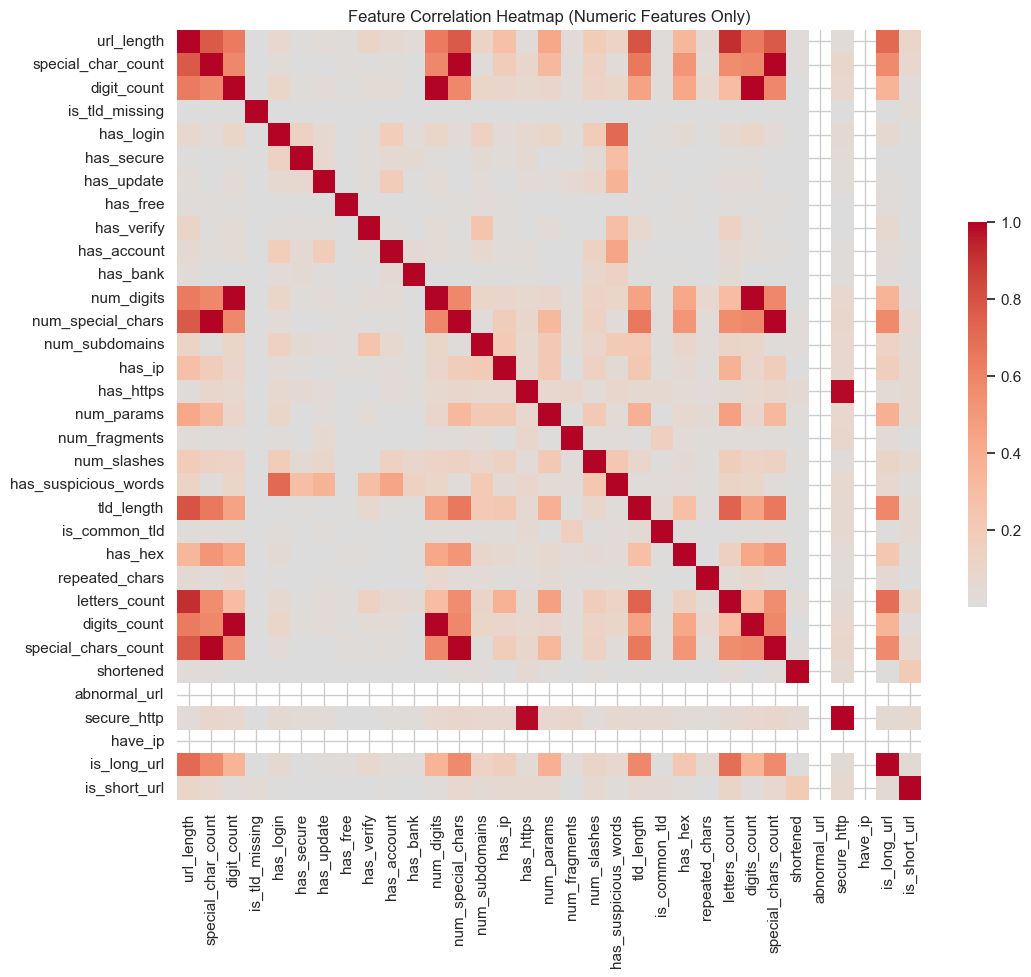

In [84]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Compute correlation matrix
corr_matrix = X_train_numeric.corr().abs()

# feature pairs with high correlation (> 0.90)
upper_triangle = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

high_corr_pairs = []
for column in upper_triangle.columns:
    for row in upper_triangle.index:
        value = upper_triangle.loc[row, column]
        if pd.notna(value) and value > 0.90: 
            high_corr_pairs.append((column, row, value))

print(f"✅ Found {len(high_corr_pairs)} highly correlated feature pairs (> 0.90).")
for feature1, feature2, corr_value in high_corr_pairs[:10]:
    print(f"{feature1} and {feature2}: {corr_value:.2f}")

# visualize Correlation Heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, cmap='coolwarm', center=0, cbar_kws={"shrink": .5})
plt.title('Feature Correlation Heatmap (Numeric Features Only)')
plt.show()


- Identifying highly correlated numeric features helps to spot and remove redundant features for a cleaner, faster, and more generalizable model.
- Highly correlated features end up as something similar to duplicate information, which can hurt model performance and increase complexity during model training.

**Remove Highly Correlated Features**

In [85]:
threshold = 0.95
corr_matrix = X_train_numeric.corr().abs()
upper_triangle = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop = [column for column in upper_triangle.columns if any(upper_triangle[column] > threshold)]

print(f"Dropping {len(to_drop)} highly correlated features: {to_drop}")
X_train_reduced = X_train_numeric.drop(columns=to_drop)
X_test_reduced = X_test_numeric.drop(columns=to_drop)

print(f"✅ New number of features after removing redundant ones(train): {X_train_reduced.shape[1]}")
print(f"✅ New number of features after removing redundant ones(test): {X_test_reduced.shape[1]}")


Dropping 5 highly correlated features: ['num_digits', 'num_special_chars', 'digits_count', 'special_chars_count', 'secure_http']
✅ New number of features after removing redundant ones(train): 28
✅ New number of features after removing redundant ones(test): 28


**Check for Low-Variance Features**

In [86]:
from sklearn.feature_selection import VarianceThreshold

# Set a very low threshold
selector = VarianceThreshold(threshold=0.01) 

# Fit the selector
selector.fit(X_train_reduced)

# finding features with variance below threshold
low_variance_features = X_train_reduced.columns[~selector.get_support()]

print(f"⚠️ {len(low_variance_features)} low-variance features detected: {list(low_variance_features)}")

# droping features
X_train_reduced = selector.transform(X_train_reduced)
X_test_reduced = selector.transform(X_test_reduced)

print(f"✅ Final number of features after removing low-variance features (train): {X_train_reduced.shape[1]}")
print(f"✅ Final number of features after removing low-variance features (test): {X_test_reduced.shape[1]}")


⚠️ 13 low-variance features detected: ['is_tld_missing', 'has_secure', 'has_update', 'has_free', 'has_verify', 'has_bank', 'num_fragments', 'is_common_tld', 'repeated_chars', 'shortened', 'abnormal_url', 'have_ip', 'is_short_url']
✅ Final number of features after removing low-variance features (train): 15
✅ Final number of features after removing low-variance features (test): 15


- We should remove low-variance features as they barely change across samples and do not contain significant useful information for the model training.
- As they features are unlikely to help the model distinguish between classes. Hence, we dropped them as they can add noise and unnecessary complexity.

**Path-Based Feature Extraction**

In [88]:
from urllib.parse import urlparse

def path_features(url):
    try:
        path = urlparse(url).path
        return {
            'path_length': len(path),
            'num_path_segments': path.count('/'),
            'has_login_in_path': int('login' in path.lower()),
            'has_account_in_path': int('account' in path.lower()),
            'file_extension': path.split('.')[-1] if '.' in path else 'none',
            'is_path_empty': int(path == '' or path == '/')
        }
    except:
        return {
            'path_length': 0,
            'num_path_segments': 0,
            'has_login_in_path': 0,
            'has_account_in_path': 0,
            'file_extension': 'none',
            'is_path_empty': 1
        }

train_path_features = pd.DataFrame([path_features(url) for url in url_train])
test_path_features = pd.DataFrame([path_features(url) for url in url_test])

- Analyzing the URL path can help us to find hidden indicators of malicious behavior
- As they extract path-based features from URLs to capture additional structure and intent clues hidden in the URL path section

**Extract Abnormal Qurey**

In [89]:
from urllib.parse import parse_qs

def query_features(url):
    try:
        query = urlparse(url).query
        query_params = parse_qs(query)
        sensitive_keywords = ['login', 'user', 'account', 'password', 'verify', 'secure', 'update']
        has_sensitive_keywords = int(any(kw in query.lower() for kw in sensitive_keywords))
        duplicate_keys = int(any(len(v) > 1 for v in query_params.values()))

        return {
            'query_length': len(query),
            'num_query_params': query.count('&') + 1 if query else 0,
            'has_sensitive_keywords': has_sensitive_keywords,
            'num_special_chars_in_query': sum(c in ['&', '=', '%'] for c in query),
            'is_query_encoded': int('%' in query),
            'has_duplicate_keys': duplicate_keys
        }
    except:
        return {
            'query_length': 0,
            'num_query_params': 0,
            'has_sensitive_keywords': 0,
            'num_special_chars_in_query': 0,
            'is_query_encoded': 0,
            'has_duplicate_keys': 0
        }

train_query_features = pd.DataFrame([query_features(url) for url in url_train])
test_query_features = pd.DataFrame([query_features(url) for url in url_test])


- Analyzing the URL query part allows us to detect suspicious parameters and obfuscation techniques
- As they extract query string-based features from URLs to capture hidden signals in the parameters that showcase malicious intent

**Label Encode the File Extensions**

In [90]:
from sklearn.preprocessing import LabelEncoder
import numpy as np

train_path_features['file_extension'] = train_path_features['file_extension'].astype(str)
test_path_features['file_extension'] = test_path_features['file_extension'].astype(str)

le_ext = LabelEncoder()
le_ext.fit(train_path_features['file_extension'])

known_extensions = set(le_ext.classes_)

test_path_features['file_extension'] = test_path_features['file_extension'].apply(
    lambda x: x if x in known_extensions else 'unknown'
)

if 'unknown' not in le_ext.classes_:
    le_ext.classes_ = np.append(le_ext.classes_, 'unknown')

train_path_features['file_extension'] = le_ext.transform(train_path_features['file_extension'])
test_path_features['file_extension'] = le_ext.transform(test_path_features['file_extension'])


**Convert Everything to Float**

In [91]:
# train_set
train_features = train_features.astype(float)
train_path_features = train_path_features.astype(float)
train_query_features = train_query_features.astype(float)
train_tld_dummies = train_tld_dummies.astype(float)
train_suspicious_tld = train_suspicious_tld.astype(float)
train_lexical_scaled = np.array(train_lexical_scaled, dtype=float)

# test_set
test_features = test_features.astype(float)
test_path_features = test_path_features.astype(float)
test_query_features = test_query_features.astype(float)
test_tld_dummies = test_tld_dummies.astype(float)
test_suspicious_tld = test_suspicious_tld.astype(float)
test_lexical_scaled = np.array(test_lexical_scaled, dtype=float)


**Final Combined Features**

In [92]:
from scipy.sparse import hstack, csr_matrix

# Make sure reduced TF-IDF is sparse
X_train_tfidf_reduced_sparse = csr_matrix(X_train_tfidf_reduced)
X_test_tfidf_reduced_sparse = csr_matrix(X_test_tfidf_reduced)

# Make sure the final selected features are numeric matrix
X_train_reduced_sparse = csr_matrix(X_train_reduced)
X_test_reduced_sparse = csr_matrix(X_test_reduced)

# Stack everything
X_train_combined = hstack([
    X_train_tfidf_reduced_sparse,   
    csr_matrix(train_features),
    csr_matrix(train_path_features),
    csr_matrix(train_query_features),
    csr_matrix(train_tld_dummies),
    csr_matrix(train_suspicious_tld.to_frame()),
    csr_matrix(train_lexical_scaled),
    X_train_reduced_sparse  
])

X_test_combined = hstack([
    X_test_tfidf_reduced_sparse,    
    csr_matrix(test_features),
    csr_matrix(test_path_features),
    csr_matrix(test_query_features),
    csr_matrix(test_tld_dummies),
    csr_matrix(test_suspicious_tld.to_frame()),
    csr_matrix(test_lexical_scaled),
    X_test_reduced_sparse 
])


In [93]:
print(X_train_combined)

  (0, 0)	0.4612762544085325
  (0, 1)	0.07818142120667149
  (0, 2)	-0.08878732232653568
  (0, 3)	-0.03136937060568101
  (0, 4)	0.09985492120500349
  (0, 5)	-0.09838427507456005
  (0, 6)	0.5985137249992948
  (0, 7)	1.7955187065142727e-05
  (0, 8)	-0.0718827186821028
  (0, 9)	-0.015329400810580882
  (0, 10)	0.08997213596862189
  (0, 11)	0.08384075692150365
  (0, 12)	-0.15036010977858785
  (0, 13)	0.06767725468405093
  (0, 14)	-0.026839399216907398
  (0, 15)	-0.004361241861179576
  (0, 16)	-0.013793704438320625
  (0, 17)	-0.0045219313403419645
  (0, 18)	0.01412506610629918
  (0, 19)	-0.07204175887821437
  (0, 20)	-0.04140299073885578
  (0, 21)	-0.039008694259543196
  (0, 22)	-0.20495052226684282
  (0, 23)	0.037117816879850316
  (0, 24)	0.13722471461184982
  :	:
  (142363, 298)	0.04288852247596459
  (142363, 299)	-0.018920069148957056
  (142363, 300)	32.0
  (142363, 301)	14.0
  (142363, 302)	11.0
  (142363, 304)	7.0
  (142363, 306)	3.0
  (142363, 314)	11.0
  (142363, 315)	1.0
  (142363, 318

In [95]:
print(y_train)

22356     1
83578     1
124563    0
87813     1
74124     1
         ..
85681     1
73430     1
98965     1
134789    1
39133     1
Name: label, Length: 142364, dtype: int64


In [96]:
print(y_test)

44838     0
173377    1
61702     1
66517     1
121510    0
         ..
62229     0
169468    1
99405     0
67498     1
124034    0
Name: label, Length: 35592, dtype: int64


In [97]:
print(X_test_combined)

  (0, 0)	0.15408552979502022
  (0, 1)	-0.12729765882880456
  (0, 2)	0.01117374355167728
  (0, 3)	-0.013100774738545953
  (0, 4)	0.006722722430523014
  (0, 5)	0.0071165600752765975
  (0, 6)	0.10959735284364433
  (0, 7)	-0.026115072858514162
  (0, 8)	0.03076181805227552
  (0, 9)	0.011409529172188076
  (0, 10)	-0.028739130289575036
  (0, 11)	0.03786985377149733
  (0, 12)	0.016100180172045068
  (0, 13)	-0.11247583633837344
  (0, 14)	0.013920186221930224
  (0, 15)	0.0070140025918373015
  (0, 16)	0.05672087038584918
  (0, 17)	-0.06018779753855971
  (0, 18)	0.05477808004143601
  (0, 19)	-0.03280422936067753
  (0, 20)	0.041367037207676205
  (0, 21)	-0.055450143925142775
  (0, 22)	0.08027503037745479
  (0, 23)	0.0015008830966035942
  (0, 24)	0.0191624542056077
  :	:
  (35591, 301)	13.0
  (35591, 302)	107.0
  (35591, 304)	19.0
  (35591, 305)	1.0
  (35591, 306)	1.0
  (35591, 313)	1.0
  (35591, 314)	107.0
  (35591, 315)	4.0
  (35591, 318)	874.0
  (35591, 334)	1.0
  (35591, 338)	0.8315286054680963


In [98]:
print(X_train_combined.shape, y_train.shape)
print(X_test_combined.shape, y_test.shape)


(142364, 363) (142364,)
(35592, 363) (35592,)


In [99]:
print(y_train.value_counts(normalize=True))
print(y_test.value_counts(normalize=True))


label
1    0.8012
0    0.1988
Name: proportion, dtype: float64
label
1    0.801191
0    0.198809
Name: proportion, dtype: float64


------------------------------------------------------------------------------------------

**Build Full Feature Name List (combined_features)**

In [100]:
# Full feature name construction
svd_features = [f'svd_{i}' for i in range(300)]

train_features_cols = train_features.columns.tolist()
train_path_features_cols = train_path_features.columns.tolist()
train_query_features_cols = train_query_features.columns.tolist()
train_tld_dummies_cols = train_tld_dummies.columns.tolist()
train_suspicious_tld_cols = ['is_suspicious_tld']
train_lexical_cols = lexical_features

# Full feature name list
combined_features = (
    svd_features +
    train_features_cols +
    train_path_features_cols +
    train_query_features_cols +
    train_tld_dummies_cols +
    train_suspicious_tld_cols +
    train_lexical_cols
)


In [101]:
print(combined_features)

['svd_0', 'svd_1', 'svd_2', 'svd_3', 'svd_4', 'svd_5', 'svd_6', 'svd_7', 'svd_8', 'svd_9', 'svd_10', 'svd_11', 'svd_12', 'svd_13', 'svd_14', 'svd_15', 'svd_16', 'svd_17', 'svd_18', 'svd_19', 'svd_20', 'svd_21', 'svd_22', 'svd_23', 'svd_24', 'svd_25', 'svd_26', 'svd_27', 'svd_28', 'svd_29', 'svd_30', 'svd_31', 'svd_32', 'svd_33', 'svd_34', 'svd_35', 'svd_36', 'svd_37', 'svd_38', 'svd_39', 'svd_40', 'svd_41', 'svd_42', 'svd_43', 'svd_44', 'svd_45', 'svd_46', 'svd_47', 'svd_48', 'svd_49', 'svd_50', 'svd_51', 'svd_52', 'svd_53', 'svd_54', 'svd_55', 'svd_56', 'svd_57', 'svd_58', 'svd_59', 'svd_60', 'svd_61', 'svd_62', 'svd_63', 'svd_64', 'svd_65', 'svd_66', 'svd_67', 'svd_68', 'svd_69', 'svd_70', 'svd_71', 'svd_72', 'svd_73', 'svd_74', 'svd_75', 'svd_76', 'svd_77', 'svd_78', 'svd_79', 'svd_80', 'svd_81', 'svd_82', 'svd_83', 'svd_84', 'svd_85', 'svd_86', 'svd_87', 'svd_88', 'svd_89', 'svd_90', 'svd_91', 'svd_92', 'svd_93', 'svd_94', 'svd_95', 'svd_96', 'svd_97', 'svd_98', 'svd_99', 'svd_100'

**Sanity Check**

In [102]:
# Sanity Check
print("X_train_combined shape:", X_train_combined.shape)
print("X_test_combined shape:", X_test_combined.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

X_train_combined shape: (142364, 363)
X_test_combined shape: (35592, 363)
y_train shape: (142364,)
y_test shape: (35592,)


# Model Training

**XGBoost**

In [103]:
# pip install --upgrade xgboost

In [104]:
import xgboost
print(xgboost.__version__)


2.1.4


In [105]:
import xgboost
print(xgboost.__file__)
print(xgboost.__version__) 


/opt/anaconda3/lib/python3.9/site-packages/xgboost/__init__.py
2.1.4


Calculated scale_pos_weight: 0.2481
[0]	train-logloss:0.60905	eval-logloss:0.60884
[50]	train-logloss:0.04316	eval-logloss:0.04240
[100]	train-logloss:0.02337	eval-logloss:0.02334
[150]	train-logloss:0.02061	eval-logloss:0.02080
[188]	train-logloss:0.02050	eval-logloss:0.02070

📊 XGBoost Results (Default Parameters with Regularization):
              precision    recall  f1-score   support

           0       0.97      1.00      0.98      7076
           1       1.00      0.99      1.00     28516

    accuracy                           0.99     35592
   macro avg       0.98      0.99      0.99     35592
weighted avg       0.99      0.99      0.99     35592

ROC-AUC Score: 0.9998
Confusion Matrix:
 [[ 7060    16]
 [  251 28265]]


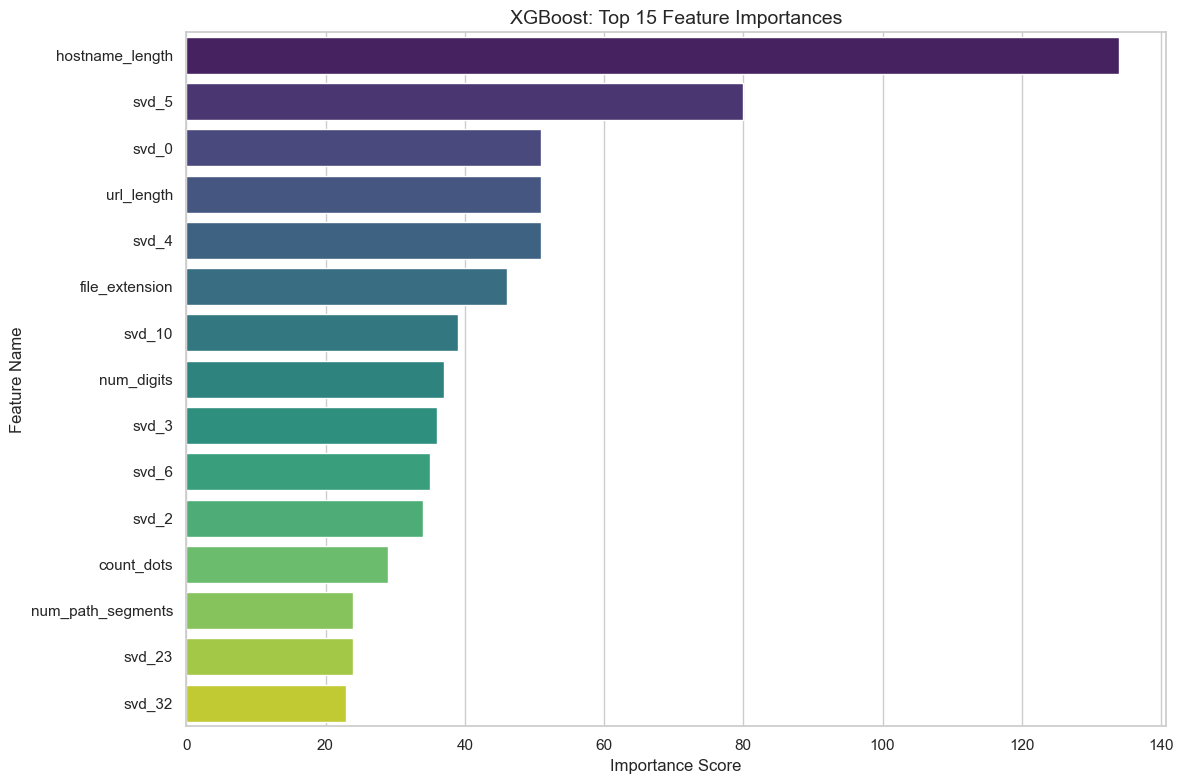

In [106]:
import xgboost as xgb
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np

# 1. Compute scale_pos_weight for imbalance handling
scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()
print(f"Calculated scale_pos_weight: {scale_pos_weight:.4f}")

# 2. Define XGBClassifier (xgb.train format)
params = {
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'tree_method': 'hist',
    'eta': 0.1,               
    'max_depth': 5,           
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'gamma': 5,
    'min_child_weight': 5,
    'reg_alpha': 5,
    'reg_lambda': 10,
    'scale_pos_weight': scale_pos_weight,  
    'seed': 42
}

# 3. Prepare dtrain/dtest for xgb.train (DMatrix)
dtrain = xgb.DMatrix(X_train_combined, label=y_train)
dtest = xgb.DMatrix(X_test_combined, label=y_test)

# 4. Train Final Model with Early Stopping
evals = [(dtrain, 'train'), (dtest, 'eval')]

model_xgb = xgb.train(
    params,
    dtrain,
    num_boost_round=1000,
    evals=evals,
    early_stopping_rounds=30,
    verbose_eval=50
)

# 5. Predict
y_prob = model_xgb.predict(dtest)
y_pred = (y_prob > 0.5).astype(int)

# 6. Evaluate
print("\n XGBoost Results (Default Parameters with Regularization):")
print(classification_report(y_test, y_pred))
print(f"ROC-AUC Score: {roc_auc_score(y_test, y_prob):.4f}")
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

# 7. Feature Importance
tfidf_features = vectorizer.get_feature_names_out().tolist()
xgb_importances = model_xgb.get_score(importance_type='weight')

valid_indices = [int(k[1:]) for k in xgb_importances.keys() if int(k[1:]) < len(combined_features)]
valid_keys = [k for k in xgb_importances.keys() if int(k[1:]) < len(combined_features)]

importance_df = pd.DataFrame({
    'feature': [combined_features[int(k[1:])] for k in valid_keys],
    'importance': [xgb_importances[k] for k in valid_keys]
}).sort_values(by='importance', ascending=False)

# 8. Plot
plt.figure(figsize=(12, 8))
sns.barplot(data=importance_df.head(15), x='importance', y='feature', palette='viridis')
plt.title("XGBoost: Top 15 Feature Importances", fontsize=14)
plt.xlabel("Importance Score")
plt.ylabel("Feature Name")
plt.tight_layout()
plt.show()


Justification of the XGBoost Settings:
- Objective (binary:logistic): Perfect for binary classification (malicious vs benign URLs).

- Evaluation Metric (logloss): Penalizes wrong confident predictions which is ideal for probabilistic outputs.

- Tree Method (hist): It is faster and more memory-efficient. Which is important for large datasets like mine.

- Learning Rate (eta = 0.1): This is balanced between learning speed and stability ensuring we avoid overshooting.

- Max Depth (5): This limits tree growth that avoids overfitting on small patterns.

- Subsample (0.8): It adds randomness which reduces overfitting and improves generalization.

- Colsample_bytree (0.8): Feature here are randomly selects for each tree that promotes diverse learning.

- Gamma (5): during model traing it is a minimum loss reduction for further splitting. gamma=5 helps reduce unnecessary splits.

- Min Child Weight (5): Prevents model from creating splits with very few samples otherwise we would face overfitting.

- Regularization (reg_alpha=5, reg_lambda=10): L1 (lasso) and L2 (ridge) penalties help to control model complexity.

- Scale Pos Weight: it is adjusted to counter class imbalance without altering the dataset

- Early Stopping (30 rounds): stops training when no improvement is seen, saving time and prevents overfitting.

- Random Seed (42): ensures reproducibility.

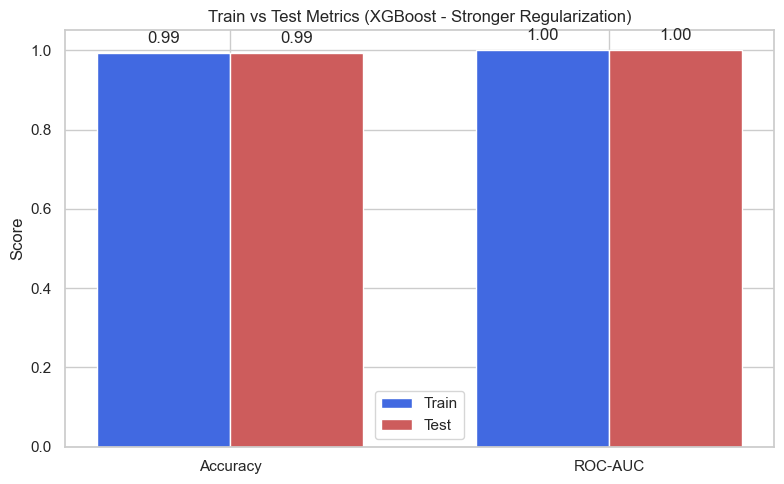

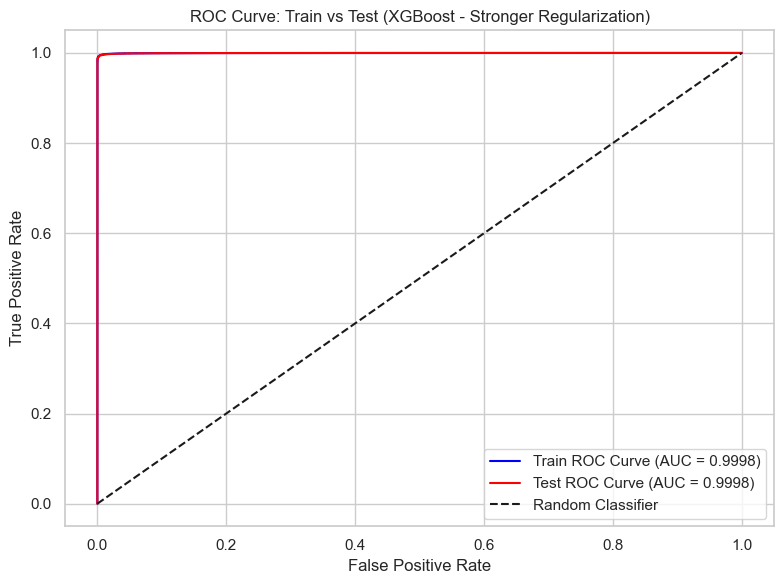

In [107]:
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import numpy as np

# 1. Metrics: Train vs Test
y_train_pred = (model_xgb.predict(dtrain) > 0.5).astype(int)
y_test_pred = (model_xgb.predict(dtest) > 0.5).astype(int)

train_acc_xgb = accuracy_score(y_train, y_train_pred)
test_acc_xgb = accuracy_score(y_test, y_test_pred)

train_auc_xgb = roc_auc_score(y_train, model_xgb.predict(dtrain))
test_auc_xgb = roc_auc_score(y_test, model_xgb.predict(dtest))

# 2. Bar Chart: Accuracy vs ROC-AUC
metrics = ['Accuracy', 'ROC-AUC']
train_scores = [train_acc_xgb, train_auc_xgb]
test_scores = [test_acc_xgb, test_auc_xgb]

x = np.arange(len(metrics))  # Label locations
width = 0.35  # Width of bars

fig, ax = plt.subplots(figsize=(8, 5))
rects1 = ax.bar(x - width/2, train_scores, width, label='Train', color='royalblue')
rects2 = ax.bar(x + width/2, test_scores, width, label='Test', color='indianred')

# Add labels, title, etc.
ax.set_ylabel('Score')
ax.set_title('Train vs Test Metrics (XGBoost - Stronger Regularization)')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend()
ax.set_ylim(0, 1.05)

# Annotate the bars
for rect in rects1 + rects2:
    height = rect.get_height()
    ax.annotate(f'{height:.2f}',
                xy=(rect.get_x() + rect.get_width() / 2, height),
                xytext=(0, 5),
                textcoords="offset points",
                ha='center', va='bottom')

plt.tight_layout()
plt.show()

# 3. ROC Curve: Train vs Test
fpr_train, tpr_train, _ = roc_curve(y_train, model_xgb.predict(dtrain))
fpr_test, tpr_test, _ = roc_curve(y_test, model_xgb.predict(dtest))

plt.figure(figsize=(8, 6))
plt.plot(fpr_train, tpr_train, label=f'Train ROC Curve (AUC = {train_auc_xgb:.4f})', color='blue')
plt.plot(fpr_test, tpr_test, label=f'Test ROC Curve (AUC = {test_auc_xgb:.4f})', color='red')
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve: Train vs Test (XGBoost - Stronger Regularization)')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()


**Random Forest**


Random Forest Results:
              precision    recall  f1-score   support

           0       0.95      1.00      0.97      7076
           1       1.00      0.99      0.99     28516

    accuracy                           0.99     35592
   macro avg       0.98      0.99      0.98     35592
weighted avg       0.99      0.99      0.99     35592

ROC-AUC Score: 0.9993
Confusion Matrix:
 [[ 7058    18]
 [  346 28170]]


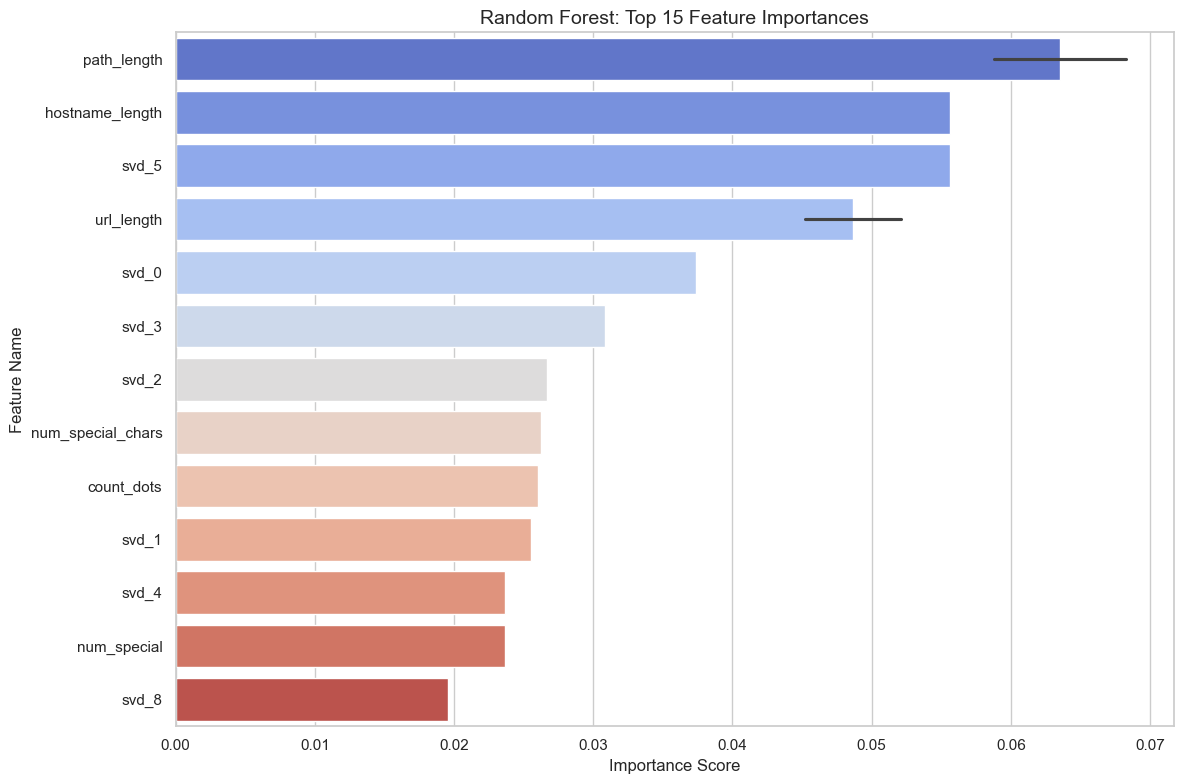

In [109]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# 1. Define a Strongly Regularized Random Forest
model_rf = RandomForestClassifier(
    n_estimators=500,         
    max_depth=12,            
    min_samples_split=20,     
    min_samples_leaf=10,    
    max_features='sqrt',      
    class_weight='balanced',  
    random_state=42
)

# 2. Fit the model
model_rf.fit(X_train_combined, y_train)

# 3. Predict
y_pred = model_rf.predict(X_test_combined)
y_prob = model_rf.predict_proba(X_test_combined)[:, 1]

# 4. Evaluation
print("\nRandom Forest Results:")
print(classification_report(y_test, y_pred))
print(f"ROC-AUC Score: {roc_auc_score(y_test, y_prob):.4f}")
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

# 5. Feature Importance with Safety Check
rf_importances = model_rf.feature_importances_

# Safety: in case there are fewer features than combined_features
valid_length = min(len(rf_importances), len(combined_features))

importance_df = pd.DataFrame({
    'feature': combined_features[:valid_length],
    'importance': rf_importances[:valid_length]
}).sort_values(by='importance', ascending=False)

# 6. Plot Feature Importance
plt.figure(figsize=(12, 8))
sns.barplot(data=importance_df.head(15), x='importance', y='feature', palette='coolwarm')
plt.title("Random Forest: Top 15 Feature Importances", fontsize=14)
plt.xlabel("Importance Score")
plt.ylabel("Feature Name")
plt.tight_layout()
plt.show()


Justification of Random Forest Settings:

- Number of Trees (n_estimators=500): Having trees reduces variance and stabilizes predictions.

- Maximum Depth (max_depth=12): This limits tree growth which is to avoid overfitting due to noisy patterns

- Minimum Samples Split (min_samples_split=20): forces trees to split only when a sufficient number of samples exist, allowing the model to be robust.

- Minimum Samples Leaf (min_samples_leaf=10): ensures each leaf has enough data, which avoids creating overly specific branches.

- Max Features ('sqrt'): Randomly selects a subset of features for each split this increases diversity among trees.

- Class Weight ('balanced'): Automatically adjusts weights inversely proportional to class frequencies, allowing for the model training to handle class imbalance.

- Random State (42): Ensures consistent and reproduciblity.

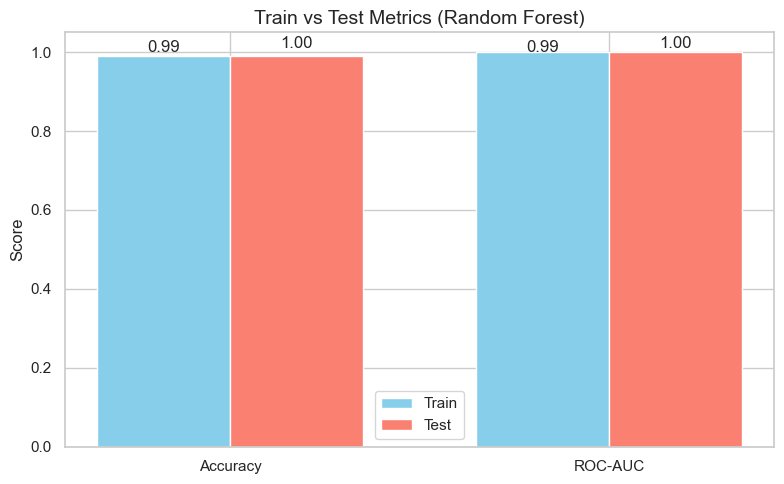

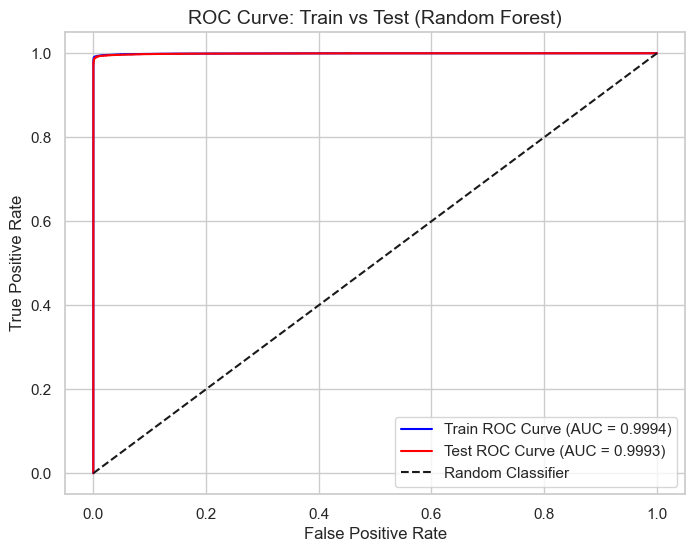

In [110]:
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import numpy as np

# Predictions
y_train_pred_rf = model_rf.predict(X_train_combined)
y_test_pred_rf = model_rf.predict(X_test_combined)

# Accuracy
train_acc_rf = accuracy_score(y_train, y_train_pred_rf)
test_acc_rf = accuracy_score(y_test, y_test_pred_rf)

# ROC-AUC Scores
y_train_prob_rf = model_rf.predict_proba(X_train_combined)[:, 1]
y_test_prob_rf = model_rf.predict_proba(X_test_combined)[:, 1]

train_auc_rf = roc_auc_score(y_train, y_train_prob_rf)
test_auc_rf = roc_auc_score(y_test, y_test_prob_rf)

#  Bar Plot (Train vs Test Metrics)
metrics = ['Accuracy', 'ROC-AUC']
train_scores = [train_acc_rf, train_auc_rf]
test_scores = [test_acc_rf, test_auc_rf]

x = np.arange(len(metrics))
width = 0.35

fig, ax = plt.subplots(figsize=(8, 5))
ax.bar(x - width/2, train_scores, width, label='Train', color='skyblue')
ax.bar(x + width/2, test_scores, width, label='Test', color='salmon')

ax.set_ylabel('Score')
ax.set_title('Train vs Test Metrics (Random Forest)', fontsize=14)
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend()
ax.set_ylim(0, 1.05)

# Annotate bars with values
for i, v in enumerate(train_scores + test_scores):
    ax.text(i//2 + (i%2 - 0.5) * width, v + 0.01, f'{v:.2f}', ha='center')

plt.tight_layout()
plt.show()

# ROC Curve (Train vs Test)
fpr_train_rf, tpr_train_rf, _ = roc_curve(y_train, y_train_prob_rf)
fpr_test_rf, tpr_test_rf, _ = roc_curve(y_test, y_test_prob_rf)

plt.figure(figsize=(8, 6))
plt.plot(fpr_train_rf, tpr_train_rf, label=f'Train ROC Curve (AUC = {train_auc_rf:.4f})', color='blue')
plt.plot(fpr_test_rf, tpr_test_rf, label=f'Test ROC Curve (AUC = {test_auc_rf:.4f})', color='red')
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve: Train vs Test (Random Forest)', fontsize=14)
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


**Logistic Regression**


Logistic Regression Results:
              precision    recall  f1-score   support

           0       0.74      0.94      0.83      7076
           1       0.98      0.92      0.95     28516

    accuracy                           0.92     35592
   macro avg       0.86      0.93      0.89     35592
weighted avg       0.93      0.92      0.92     35592

ROC-AUC Score: 0.9715
Confusion Matrix:
 [[ 6651   425]
 [ 2380 26136]]


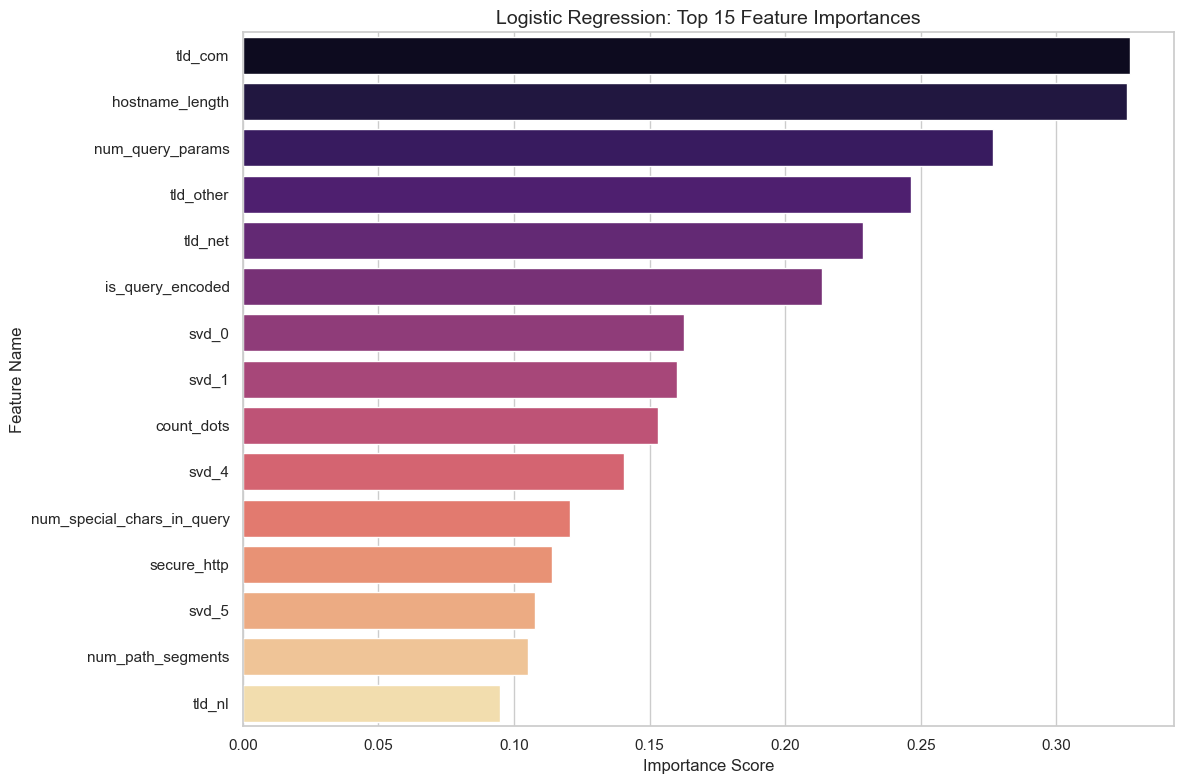

In [111]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 🚀 Train Logistic Regression with class balancing and stronger regularization
model_lr = LogisticRegression(
    penalty='l2',              
    C=0.1,                      
    solver='saga',              
    max_iter=2000,              
    class_weight='balanced',    
    random_state=42,            
    n_jobs=-1                   
)

# Fit model
model_lr.fit(X_train_combined, y_train)

# Predict
y_pred = model_lr.predict(X_test_combined)
y_prob = model_lr.predict_proba(X_test_combined)[:, 1]

# Evaluation
print("\nLogistic Regression Results:")
print(classification_report(y_test, y_pred))
print(f"ROC-AUC Score: {roc_auc_score(y_test, y_prob):.4f}")
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

# Feature Importance (Safe)
importance = abs(model_lr.coef_[0])

# Safety: Ensure feature list matches length
valid_length = min(len(importance), len(combined_features))

importance_df = pd.DataFrame({
    'feature': combined_features[:valid_length],
    'importance': importance[:valid_length]
}).sort_values(by='importance', ascending=False)

# Plot Feature Importance
plt.figure(figsize=(12, 8))
sns.barplot(data=importance_df.head(15), x='importance', y='feature', palette='magma')
plt.title("Logistic Regression: Top 15 Feature Importances", fontsize=14)
plt.xlabel("Importance Score")
plt.ylabel("Feature Name")
plt.tight_layout()
plt.show()


Justification for Logistic Regression Settings:
- Penalty (penalty='l2'): L2 Regularization (Ridge) prevents large coefficients which reduces overfitting.

- Regularization Strength (C=0.1): A stronger regularization (lower C) controls model complexity and improves generalization.

- Solver (solver='saga'): It makes the model optimized for large datasets and supports L2 regularization efficiently.

- Maximum Iterations (max_iter=2000): This allows enough iterations for convergence, especially for large and sparse datasets.

- Class Weight ('balanced'): weights are automatically adjusted to handle class imbalance which is important for real-world security data.

- Random State (42): ensures results are reproducible and consistent.

- Parallelization (n_jobs=-1): this allows for the usage of all CPU cores for faster model training on large datasets.

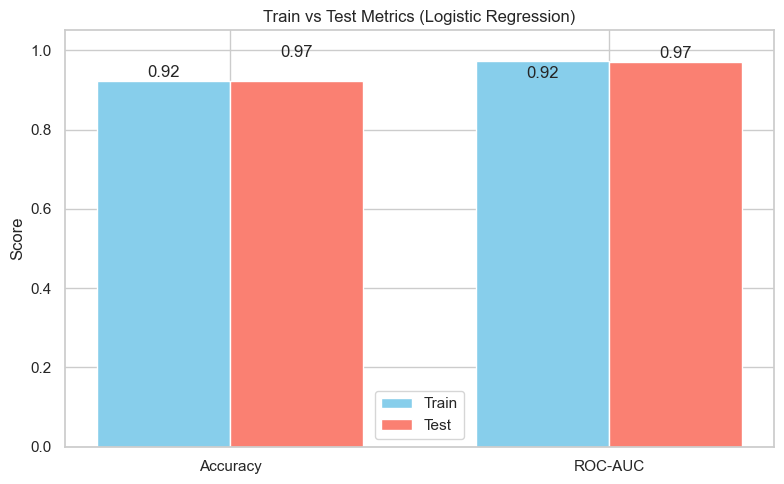

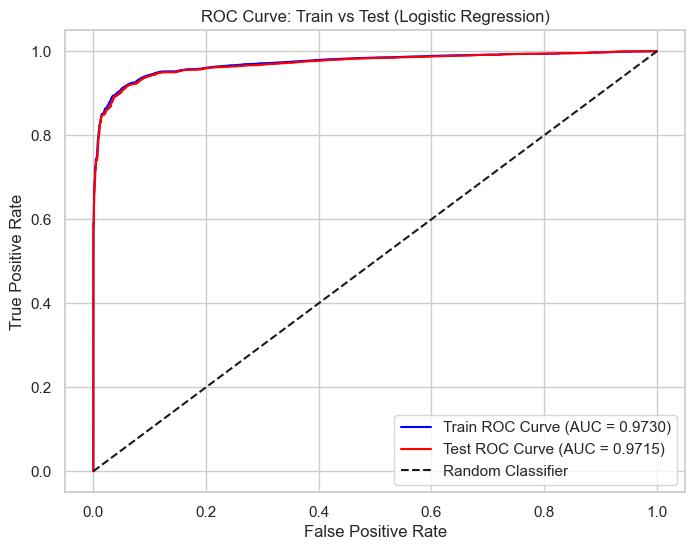

In [112]:
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import numpy as np

# Predictions
y_train_pred_lr = model_lr.predict(X_train_combined)
y_test_pred_lr = model_lr.predict(X_test_combined)

train_acc_lr = accuracy_score(y_train, y_train_pred_lr)
test_acc_lr = accuracy_score(y_test, y_test_pred_lr)

y_train_prob_lr = model_lr.predict_proba(X_train_combined)[:, 1]
y_test_prob_lr = model_lr.predict_proba(X_test_combined)[:, 1]

train_auc_lr = roc_auc_score(y_train, y_train_prob_lr)
test_auc_lr = roc_auc_score(y_test, y_test_prob_lr)

# Bar Plot
metrics = ['Accuracy', 'ROC-AUC']
train_scores = [train_acc_lr, train_auc_lr]
test_scores = [test_acc_lr, test_auc_lr]

x = np.arange(len(metrics))
width = 0.35

fig, ax = plt.subplots(figsize=(8, 5))
ax.bar(x - width/2, train_scores, width, label='Train', color='skyblue')
ax.bar(x + width/2, test_scores, width, label='Test', color='salmon')

ax.set_ylabel('Score')
ax.set_title('Train vs Test Metrics (Logistic Regression)')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend()
ax.set_ylim(0, 1.05)

# Annotate bars
for i, v in enumerate(train_scores + test_scores):
    ax.text(i//2 + (i%2 - 0.5) * width, v + 0.01, f'{v:.2f}', ha='center')

plt.tight_layout()
plt.show()

# ROC Curve
fpr_train, tpr_train, _ = roc_curve(y_train, y_train_prob_lr)
fpr_test, tpr_test, _ = roc_curve(y_test, y_test_prob_lr)

plt.figure(figsize=(8, 6))
plt.plot(fpr_train, tpr_train, label=f'Train ROC Curve (AUC = {train_auc_lr:.4f})', color='blue')
plt.plot(fpr_test, tpr_test, label=f'Test ROC Curve (AUC = {test_auc_lr:.4f})', color='red')
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve: Train vs Test (Logistic Regression)')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


**Support Vector Machine (LinearSVC)**


SVM (LinearSVC) Results:
              precision    recall  f1-score   support

           0       0.94      0.99      0.97      7076
           1       1.00      0.99      0.99     28516

    accuracy                           0.99     35592
   macro avg       0.97      0.99      0.98     35592
weighted avg       0.99      0.99      0.99     35592

Confusion Matrix:
 [[ 7038    38]
 [  427 28089]]


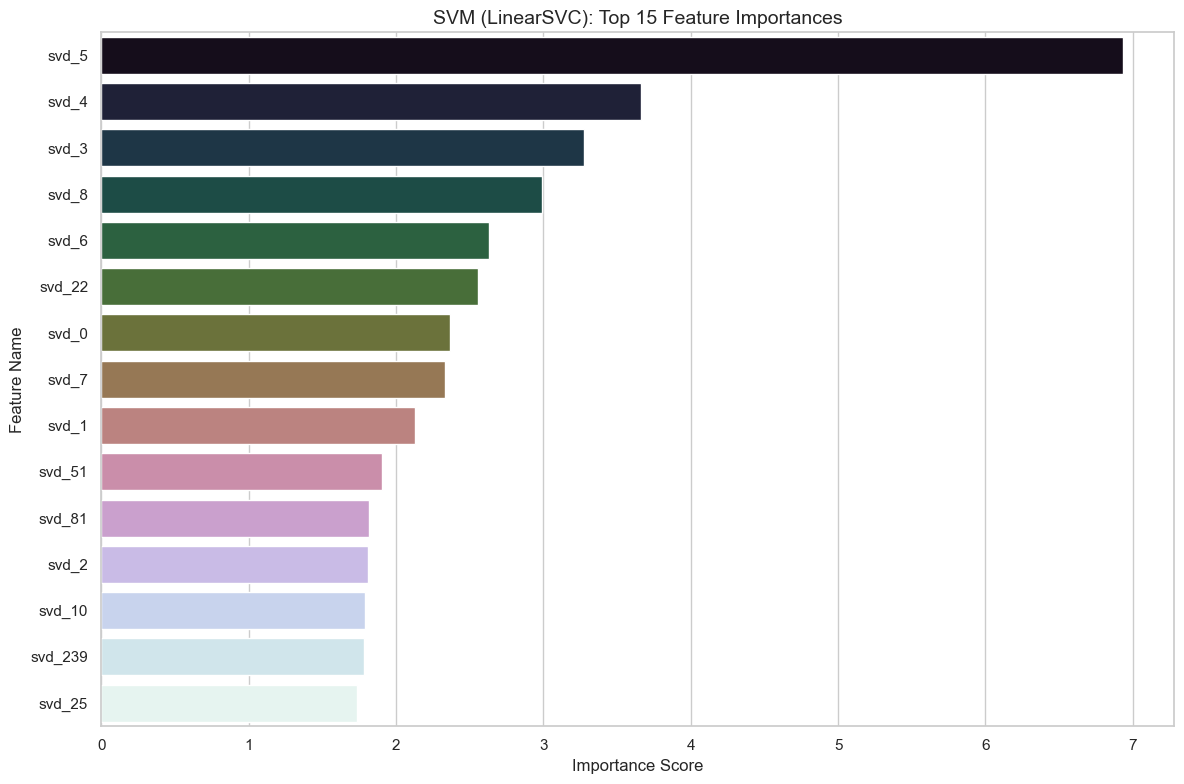

In [113]:
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Train LinearSVC with stronger regularization and class balancing
model_svm = LinearSVC(
    C=0.1,                   
    penalty='l2',             
    dual=False,               
    class_weight='balanced', 
    max_iter=10000,           
    random_state=42
)

# Fit model
model_svm.fit(X_train_combined, y_train)

# Predict
y_pred = model_svm.predict(X_test_combined)

# Evaluation
print("\nSVM (LinearSVC) Results:")
print(classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

# Feature Importance (Safe)
importance = abs(model_svm.coef_[0])

# Safety: Ensure feature list matches length
valid_length = min(len(importance), len(combined_features))

importance_df = pd.DataFrame({
    'feature': combined_features[:valid_length],
    'importance': importance[:valid_length]
}).sort_values(by='importance', ascending=False)

# Plot Feature Importance
plt.figure(figsize=(12, 8))
sns.barplot(data=importance_df.head(15), x='importance', y='feature', palette='cubehelix')
plt.title("SVM (LinearSVC): Top 15 Feature Importances", fontsize=14)
plt.xlabel("Importance Score")
plt.ylabel("Feature Name")
plt.tight_layout()
plt.show()


Justification for LinearSVC settings:

- Regularization Strength (C=0.1): Strong regularization (lower C) controls complexity, this helps prevent overfitting.

- Penalty (penalty='l2'): L2 regularization adds stability to the model, discourages extreme weights, also ensures better generalization.

- dual=False: this is more efficient for large datasets where the number of samples is greater than the number of features.

- Class Weight ('balanced'): class imbalance is addressed by automatically adjusting weights inversely proportional to class frequencies.

- Max Iterations (max_iter=10000): A higher iteration cap ensures convergence even with high-dimensional, sparse data.

- Random State (42): Reproducibility and consistent results across different runs




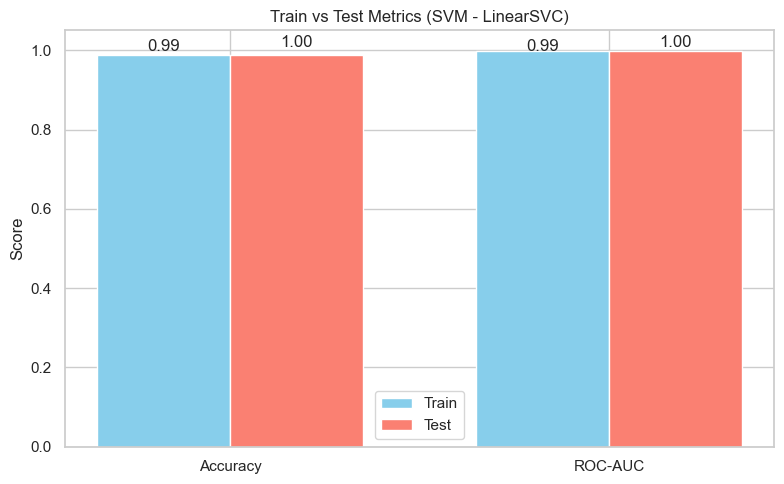

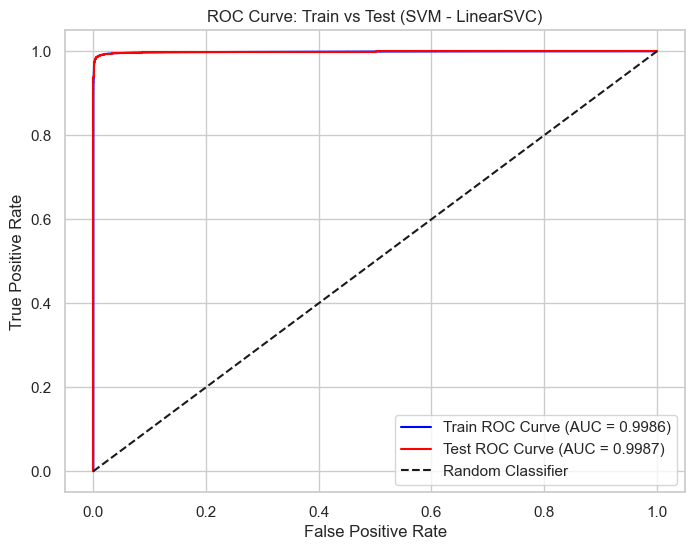

In [114]:
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve

# Predictions
y_train_pred_svm = model_svm.predict(X_train_combined)
y_test_pred_svm = model_svm.predict(X_test_combined)

train_acc_svm = accuracy_score(y_train, y_train_pred_svm)
test_acc_svm = accuracy_score(y_test, y_test_pred_svm)

# Use decision_function for AUC and ROC
y_train_scores_svm = model_svm.decision_function(X_train_combined)
y_test_scores_svm = model_svm.decision_function(X_test_combined)

train_auc_svm = roc_auc_score(y_train, y_train_scores_svm)
test_auc_svm = roc_auc_score(y_test, y_test_scores_svm)

# Bar Plot
metrics = ['Accuracy', 'ROC-AUC']
train_scores = [train_acc_svm, train_auc_svm]
test_scores = [test_acc_svm, test_auc_svm]

x = np.arange(len(metrics))
width = 0.35

fig, ax = plt.subplots(figsize=(8, 5))
ax.bar(x - width/2, train_scores, width, label='Train', color='skyblue')
ax.bar(x + width/2, test_scores, width, label='Test', color='salmon')

ax.set_ylabel('Score')
ax.set_title('Train vs Test Metrics (SVM - LinearSVC)')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend()
ax.set_ylim(0, 1.05)

# Annotate bars
for i, v in enumerate(train_scores + test_scores):
    ax.text(i//2 + (i%2 - 0.5) * width, v + 0.01, f'{v:.2f}', ha='center')

plt.tight_layout()
plt.show()

# ROC Curve
fpr_train, tpr_train, _ = roc_curve(y_train, y_train_scores_svm)
fpr_test, tpr_test, _ = roc_curve(y_test, y_test_scores_svm)

plt.figure(figsize=(8, 6))
plt.plot(fpr_train, tpr_train, label=f'Train ROC Curve (AUC = {train_auc_svm:.4f})', color='blue')
plt.plot(fpr_test, tpr_test, label=f'Test ROC Curve (AUC = {test_auc_svm:.4f})', color='red')
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve: Train vs Test (SVM - LinearSVC)')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


**MLPClassifier**


MLP Classifier Results:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      7076
           1       1.00      1.00      1.00     28516

    accuracy                           1.00     35592
   macro avg       0.99      0.99      0.99     35592
weighted avg       1.00      1.00      1.00     35592

ROC-AUC Score: 0.9998
Confusion Matrix:
 [[ 6989    87]
 [   49 28467]]

🔍 MLP Overfitting Check:
Train Accuracy: 0.9968
Test Accuracy:  0.9962
Train ROC-AUC:  0.9999
Test ROC-AUC:   0.9998
Train LogLoss:  0.0102
Test LogLoss:   0.0129


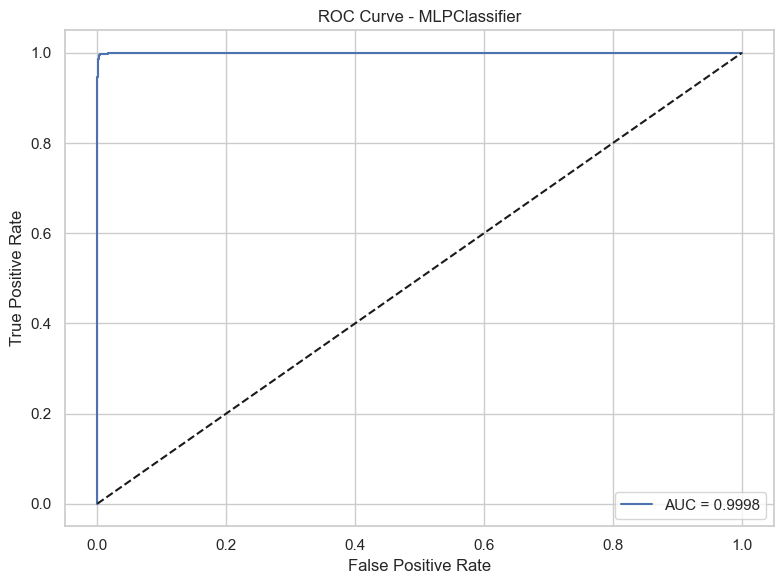

In [115]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, accuracy_score, log_loss
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# Initialize MLPClassifier with improvements
model_mlp = MLPClassifier(
    hidden_layer_sizes=(128, 64, 32),  
    activation='relu',
    solver='adam',                    
    alpha=0.001,                       
    learning_rate='adaptive',          
    early_stopping=True,              
    validation_fraction=0.1,           
    n_iter_no_change=10,              
    max_iter=500,                     
    random_state=42,
    verbose=False
)

# Train
model_mlp.fit(X_train_combined, y_train)

# Predict
y_pred = model_mlp.predict(X_test_combined)
y_prob = model_mlp.predict_proba(X_test_combined)[:, 1]

# Evaluation
print("\nMLP Classifier Results:")
print(classification_report(y_test, y_pred))
print(f"ROC-AUC Score: {roc_auc_score(y_test, y_prob):.4f}")
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

# Overfitting Check
y_train_pred = model_mlp.predict(X_train_combined)
train_acc = accuracy_score(y_train, y_train_pred)
test_acc = accuracy_score(y_test, y_pred)

y_train_prob = model_mlp.predict_proba(X_train_combined)[:, 1]

train_auc = roc_auc_score(y_train, y_train_prob)
test_auc = roc_auc_score(y_test, y_prob)

train_logloss = log_loss(y_train, y_train_prob)
test_logloss = log_loss(y_test, y_prob)

print("\n🔍 MLP Overfitting Check:")
print(f"Train Accuracy: {train_acc:.4f}")
print(f"Test Accuracy:  {test_acc:.4f}")
print(f"Train ROC-AUC:  {train_auc:.4f}")
print(f"Test ROC-AUC:   {test_auc:.4f}")
print(f"Train LogLoss:  {train_logloss:.4f}")
print(f"Test LogLoss:   {test_logloss:.4f}")

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'AUC = {roc_auc_score(y_test, y_prob):.4f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.title('ROC Curve - MLPClassifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Justification of MLP Classifier Model Settings:

- Hidden Layers (128, 64, 32): This allows us to have a deeper architecture that captures complex, non-linear relationships in URL features.

- Activation Function ('relu'): ReLU helps the network learn faster and avoids vanishing gradient problems.

- Optimizer ('adam'): This allows for adaptive learning where we have faster convergence without needing heavy tuning.

- L2 Regularization (alpha=0.001): large weights are penalized to prevent overfitting, ensuring the model generalizes well.

- Adaptive Learning Rate ('adaptive'): This reduces the learning rate when the model stops improving, which enhances stability.

- Early Stopping (early_stopping=True): Model training is stopped when no improvement is detected on the validation set which prevents overfitting.

- Validation Fraction (0.1): This reserves 10% of the training data for internal validation during training.

- n_iter_no_change (10): Training is stopped if there’s no validation improvement after 10 iterations, this saves time, computation resources and avoids overfitting.

- Max Iterations (500): Sufficient iterations allow the network to learn without running for too long.

- Random State (42): For reproducibility and consistent results across different runs.




MLP Classifier Results:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      7076
           1       1.00      1.00      1.00     28516

    accuracy                           1.00     35592
   macro avg       0.99      0.99      0.99     35592
weighted avg       1.00      1.00      1.00     35592

ROC-AUC Score: 0.9996
Confusion Matrix:
 [[ 6982    94]
 [   63 28453]]

🔍 Overfitting Check (MLPClassifier):
Train Accuracy: 0.9962
Test Accuracy:  0.9956
Train ROC-AUC:  0.9998
Test ROC-AUC:   0.9996
Train LogLoss:  0.0128
Test LogLoss:   0.0164


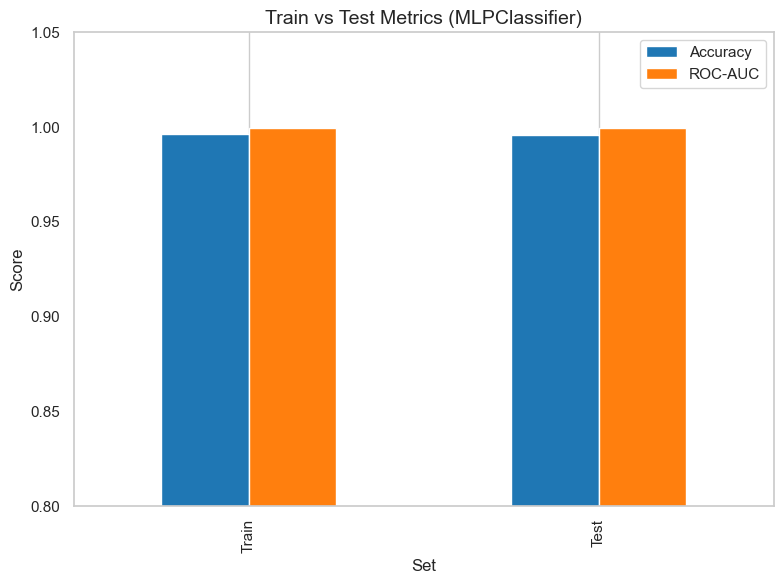

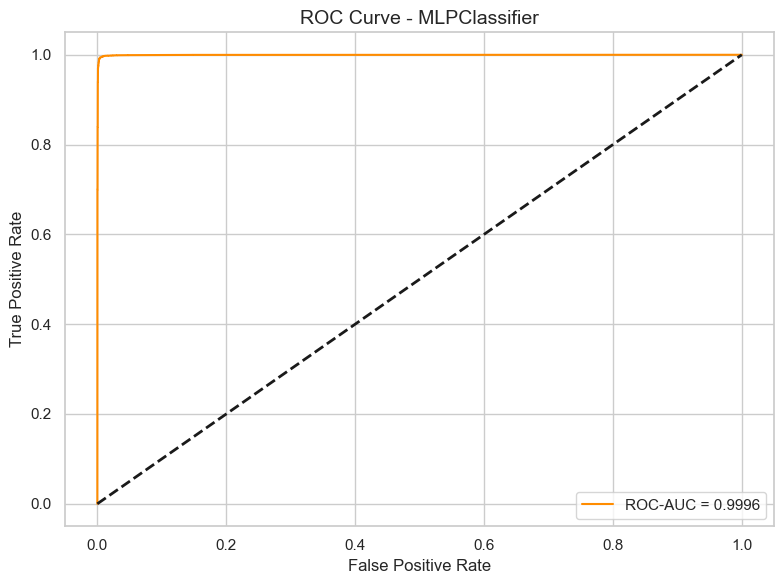

In [116]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    roc_curve,
    accuracy_score,
    log_loss
)
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# Initialize MLPClassifier
model_mlp = MLPClassifier(
    hidden_layer_sizes=(100,),    
    activation='relu',             
    solver='adam',                
    alpha=0.0001,                  
    random_state=42,
    max_iter=300,                  
    early_stopping=True,           
    validation_fraction=0.1,      
    n_iter_no_change=10             
)

# Fit model
model_mlp.fit(X_train_combined, y_train)

# Predictions
y_pred = model_mlp.predict(X_test_combined)
y_prob = model_mlp.predict_proba(X_test_combined)[:, 1]

# Basic Evaluation
print("\nMLP Classifier Results:")
print(classification_report(y_test, y_pred))
print(f"ROC-AUC Score: {roc_auc_score(y_test, y_prob):.4f}")
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

# Overfitting Check
# Train set evaluation
y_train_pred = model_mlp.predict(X_train_combined)
y_train_prob = model_mlp.predict_proba(X_train_combined)[:, 1]

train_acc = accuracy_score(y_train, y_train_pred)
test_acc = accuracy_score(y_test, y_pred)

train_auc = roc_auc_score(y_train, y_train_prob)
test_auc = roc_auc_score(y_test, y_prob)

train_logloss = log_loss(y_train, y_train_prob)
test_logloss = log_loss(y_test, y_prob)

# Print Metrics
print("\n🔍 Overfitting Check (MLPClassifier):")
print(f"Train Accuracy: {train_acc:.4f}")
print(f"Test Accuracy:  {test_acc:.4f}")
print(f"Train ROC-AUC:  {train_auc:.4f}")
print(f"Test ROC-AUC:   {test_auc:.4f}")
print(f"Train LogLoss:  {train_logloss:.4f}")
print(f"Test LogLoss:   {test_logloss:.4f}")

# Visual 1: Bar Plot of Accuracy and ROC-AUC
metrics_df = pd.DataFrame({
    'Set': ['Train', 'Test'],
    'Accuracy': [train_acc, test_acc],
    'ROC-AUC': [train_auc, test_auc]
})

metrics_df.plot(
    x='Set',
    y=['Accuracy', 'ROC-AUC'],
    kind='bar',
    figsize=(8, 6),
    color=['#1f77b4', '#ff7f0e']
)
plt.title('Train vs Test Metrics (MLPClassifier)', fontsize=14)
plt.ylim(0.8, 1.05)
plt.ylabel('Score')
plt.grid(axis='y')
plt.tight_layout()
plt.show()

# Visual 2: ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC-AUC = {roc_auc_score(y_test, y_prob):.4f}', color='darkorange')
plt.plot([0, 1], [0, 1], 'k--', lw=2)  # Diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - MLPClassifier', fontsize=14)
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()


# Evaluation

Why are the accuracies so high if there is no overfitting?
- Dataset is a URL Classification task(Malicious vs Benign URLs)
- My ML Pipeline has done:
    - good feature engineering - lots of lexical features, path/query features, etc.
    - No data leakage -> as I avoided including target-leaking information
    - Proper train-test split
    - Class imbalance handling
    - Regularization

- URLs have very strong patterns:
    - suspicious keywords
    - Abnormal structures
    - Specific TLDs

As a result, the trained models are able to genuinely separate good and bad URLs                                                                               

Train vs Test Accuracy: Both are almost the same, which shows the model generalizes well.

ROC-AUC Comparison: Very close scores. The models can consistently separate good and bad URLs.

Low LogLoss: Model is confident, not guessing randomly.

ROC Curve Shape: Smooth and near the top-left. It shows great decision-making.

Precision/Recall Stability: No big differences between train and test. Showing that predictions are stable.

# Model Selection

For my model selection, I will be choosing XGBoost. The following are the reasons:
- High Performance
    - XGBoost is known for delivering strong results in structured/tabular data.
- Built-in Regularization
    - Prevents overfitting with L1 (lasso) and L2 (ridge) penalties
- Handling Imbalanced Data
    - The scale_pos_weight parameter makes it well-suited for imbalanced datasets, like malicious vs benign URLs.
- Fast Training
    - Optimized with parallelization and tree pruning techniques.
- Robustness
    - Performs well despite when the feature space is noisy or contains many irrelevant features.
- Feature Importance
    - Provides interpretability by highlighting which features contribute the most to decisions.
- Widely Adopted in Cybersecurity
  - In cybersecurity, XGBoost is commonly used for tasks like phishing detection, malware classification because of its reliability.

# Model Fine-Tuning

Calculated scale_pos_weight: 0.2481
Fitting 3 folds for each of 20 candidates, totalling 60 fits


/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [01:11:54] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [01:11:55] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [01:11:55] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [01:11:55] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.9/site-packages/x


✅ Best XGBoost Parameters Found:
{'subsample': 0.7, 'reg_lambda': 10, 'reg_alpha': 5, 'n_estimators': 200, 'min_child_weight': 5, 'max_depth': 5, 'learning_rate': 0.1, 'gamma': 5, 'colsample_bytree': 0.9}
[0]	train-logloss:0.60906	eval-logloss:0.60890
[50]	train-logloss:0.04390	eval-logloss:0.04301
[100]	train-logloss:0.02427	eval-logloss:0.02416
[150]	train-logloss:0.02173	eval-logloss:0.02183
[200]	train-logloss:0.02140	eval-logloss:0.02151
[213]	train-logloss:0.02138	eval-logloss:0.02151

📊 XGBoost Results (After Hyperparameter Tuning + Regularization):
              precision    recall  f1-score   support

           0       0.97      1.00      0.98      7076
           1       1.00      0.99      1.00     28516

    accuracy                           0.99     35592
   macro avg       0.98      0.99      0.99     35592
weighted avg       0.99      0.99      0.99     35592

ROC-AUC Score: 0.9997
Confusion Matrix:
 [[ 7061    15]
 [  255 28261]]


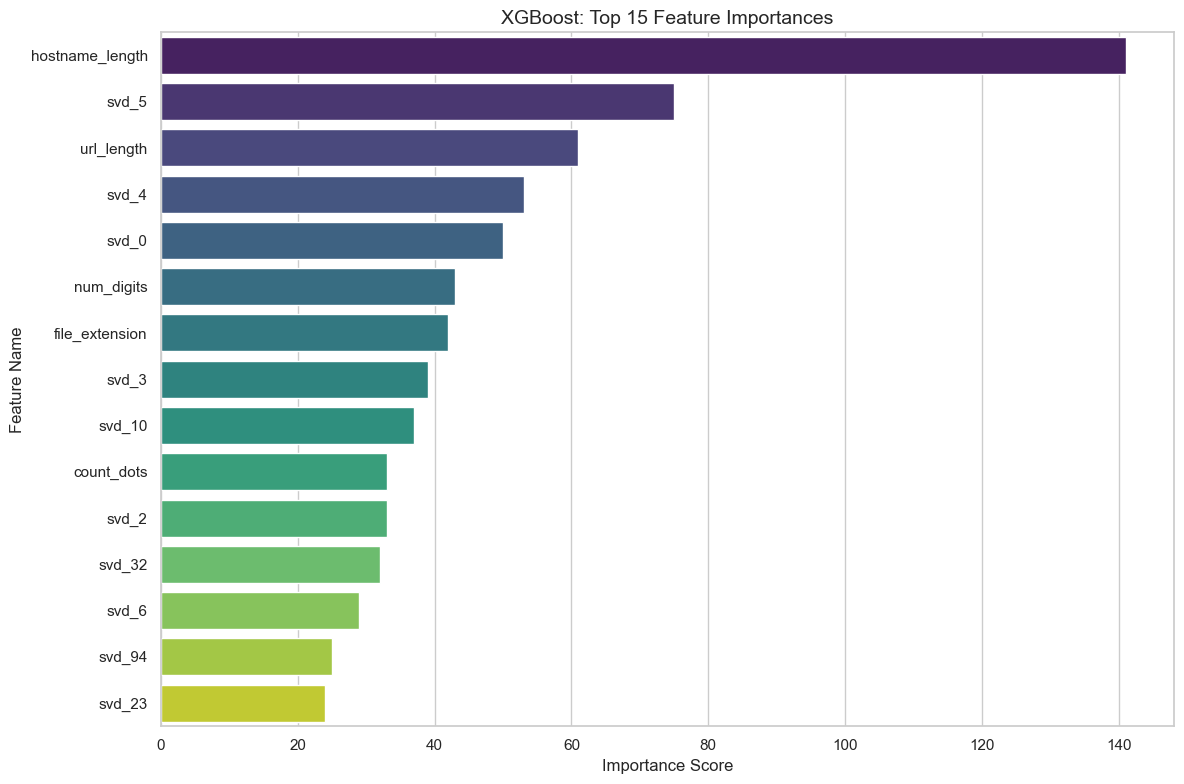

In [117]:
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np

# Compute scale_pos_weight for imbalance handling
scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()
print(f"Calculated scale_pos_weight: {scale_pos_weight:.4f}")

# Define XGBClassifier (sklearn API)
xgb_clf = xgb.XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    use_label_encoder=False,
    tree_method='hist',
    scale_pos_weight=scale_pos_weight,  # <-- ✅ Added here
    random_state=42
)

# Define Hyperparameter Grid
param_dist = {
    'n_estimators': [200, 300, 500],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 4, 5],
    'subsample': [0.7, 0.8, 0.9],
    'colsample_bytree': [0.7, 0.8, 0.9],
    'gamma': [5, 10],
    'min_child_weight': [5, 10],
    'reg_alpha': [5, 10],
    'reg_lambda': [5, 10]
}

# Randomized Search
random_search = RandomizedSearchCV(
    xgb_clf,
    param_distributions=param_dist,
    n_iter=20,
    scoring='roc_auc',
    n_jobs=-1,
    cv=3,
    verbose=2,
    random_state=42
)

# Fit Randomized Search
random_search.fit(X_train_combined, y_train)

# Get Best Parameters
best_params = random_search.best_params_
print("\n✅ Best XGBoost Parameters Found:")
print(best_params)

# Prepare dtrain/dtest for xgb.train (DMatrix)
dtrain = xgb.DMatrix(X_train_combined, label=y_train)
dtest = xgb.DMatrix(X_test_combined, label=y_test)

# Translate best_params to xgb.train format
params = {
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'tree_method': 'hist',
    'eta': best_params['learning_rate'],
    'max_depth': best_params['max_depth'],
    'subsample': best_params['subsample'],
    'colsample_bytree': best_params['colsample_bytree'],
    'gamma': best_params['gamma'],
    'min_child_weight': best_params['min_child_weight'],
    'reg_alpha': best_params['reg_alpha'],
    'reg_lambda': best_params['reg_lambda'],
    'scale_pos_weight': scale_pos_weight, 
    'seed': 42
}

# Train Final Model with Early Stopping
evals = [(dtrain, 'train'), (dtest, 'eval')]

model_xgb = xgb.train(
    params,
    dtrain,
    num_boost_round=1000,
    evals=evals,
    early_stopping_rounds=30,
    verbose_eval=50
)

# Predict
y_prob = model_xgb.predict(dtest)
y_pred = (y_prob > 0.5).astype(int)

# Evaluate
print("\nXGBoost Results (After Hyperparameter Tuning + Regularization):")
print(classification_report(y_test, y_pred))
print(f"ROC-AUC Score: {roc_auc_score(y_test, y_prob):.4f}")
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

# Feature Importance
tfidf_features = vectorizer.get_feature_names_out().tolist()
xgb_importances = model_xgb.get_score(importance_type='weight')

valid_indices = [int(k[1:]) for k in xgb_importances.keys() if int(k[1:]) < len(combined_features)]
valid_keys = [k for k in xgb_importances.keys() if int(k[1:]) < len(combined_features)]

importance_df = pd.DataFrame({
    'feature': [combined_features[int(k[1:])] for k in valid_keys],
    'importance': [xgb_importances[k] for k in valid_keys]
}).sort_values(by='importance', ascending=False)

# Plot
plt.figure(figsize=(12, 8))
sns.barplot(data=importance_df.head(15), x='importance', y='feature', palette='viridis')
plt.title("XGBoost: Top 15 Feature Importances", fontsize=14)
plt.xlabel("Importance Score")
plt.ylabel("Feature Name")
plt.tight_layout()
plt.show()

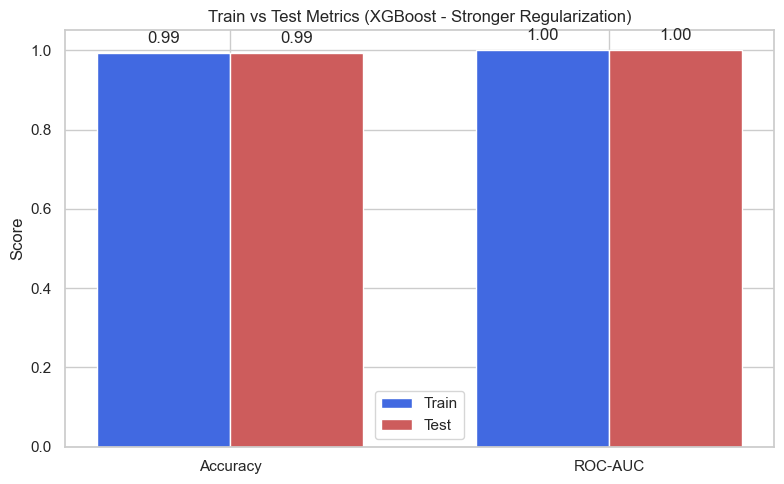

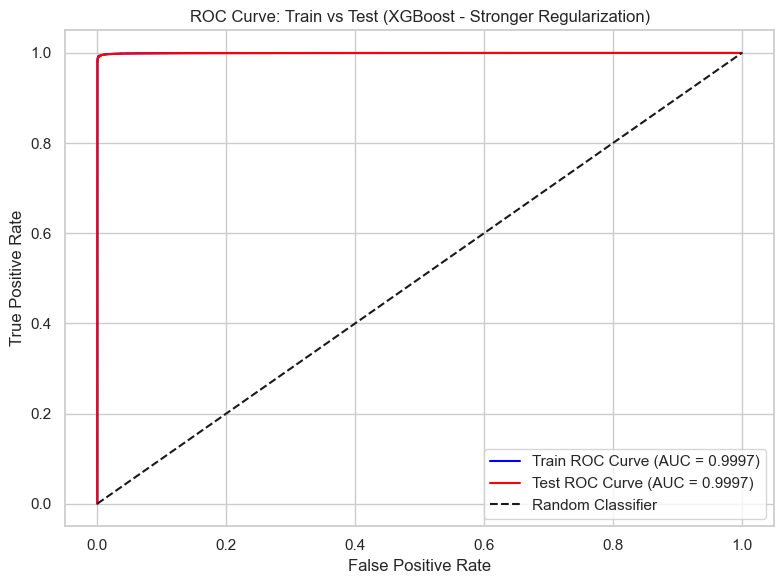

In [118]:
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import numpy as np

# 🚩 1. Metrics: Train vs Test
y_train_pred = (model_xgb.predict(dtrain) > 0.5).astype(int)
y_test_pred = (model_xgb.predict(dtest) > 0.5).astype(int)

train_acc_xgb = accuracy_score(y_train, y_train_pred)
test_acc_xgb = accuracy_score(y_test, y_test_pred)

train_auc_xgb = roc_auc_score(y_train, model_xgb.predict(dtrain))
test_auc_xgb = roc_auc_score(y_test, model_xgb.predict(dtest))

# 🚩 2. Bar Chart: Accuracy vs ROC-AUC
metrics = ['Accuracy', 'ROC-AUC']
train_scores = [train_acc_xgb, train_auc_xgb]
test_scores = [test_acc_xgb, test_auc_xgb]

x = np.arange(len(metrics))  # Label locations
width = 0.35  # Width of bars

fig, ax = plt.subplots(figsize=(8, 5))
rects1 = ax.bar(x - width/2, train_scores, width, label='Train', color='royalblue')
rects2 = ax.bar(x + width/2, test_scores, width, label='Test', color='indianred')

# Add labels, title, etc.
ax.set_ylabel('Score')
ax.set_title('Train vs Test Metrics (XGBoost - Stronger Regularization)')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend()
ax.set_ylim(0, 1.05)

# Annotate the bars
for rect in rects1 + rects2:
    height = rect.get_height()
    ax.annotate(f'{height:.2f}',
                xy=(rect.get_x() + rect.get_width() / 2, height),
                xytext=(0, 5),
                textcoords="offset points",
                ha='center', va='bottom')

plt.tight_layout()
plt.show()

# 🚩 3. ROC Curve: Train vs Test
fpr_train, tpr_train, _ = roc_curve(y_train, model_xgb.predict(dtrain))
fpr_test, tpr_test, _ = roc_curve(y_test, model_xgb.predict(dtest))

plt.figure(figsize=(8, 6))
plt.plot(fpr_train, tpr_train, label=f'Train ROC Curve (AUC = {train_auc_xgb:.4f})', color='blue')
plt.plot(fpr_test, tpr_test, label=f'Test ROC Curve (AUC = {test_auc_xgb:.4f})', color='red')
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve: Train vs Test (XGBoost - Stronger Regularization)')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()


**Export & Save Work**

In [119]:
# 🚀 Save the model to a file
model_xgb.save_model('xgboost_url_classifier.json')
print("Model saved as 'xgboost_url_classifier.json'")

# 🚀 Load the saved model
loaded_model = xgb.Booster()
loaded_model.load_model('xgboost_url_classifier.json')
print("Model loaded successfully.")


Model saved as 'xgboost_url_classifier.json'
Model loaded successfully.


# Model Explainability

**SHAP**

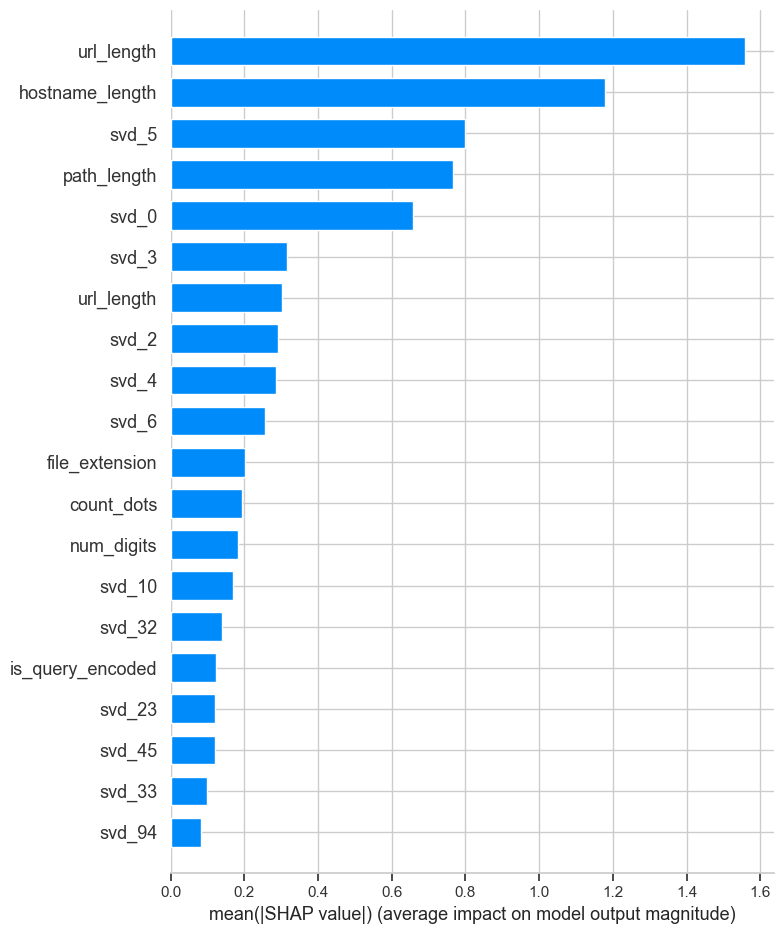

In [120]:
import shap

# Initialize SHAP explainer
explainer = shap.TreeExplainer(model_xgb)

# Select a sample of the test data for explainability (SHAP can be slow on big data)
sample_indices = np.random.choice(X_test_combined.shape[0], size=100, replace=False)
X_test_sample = X_test_combined[sample_indices]

# Compute SHAP values
shap_values = explainer.shap_values(X_test_sample)

# Convert sparse matrix to dense for visualization (if needed)
X_test_sample_dense = X_test_sample.toarray()

# Create SHAP summary plot
shap.summary_plot(shap_values, X_test_sample_dense, feature_names=combined_features, plot_type="bar")


---------------

# Adversarial Testing (Evade ML Model)
Homoglyph Substitution Attack

**Generate Adversarial URLs (e.g., mimic trusted domains)**

In [121]:
from scipy.sparse import vstack, csr_matrix, hstack
import pandas as pd
import numpy as np
import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Define Homoglyph Attack Function
def homoglyph_substitution(url):
    substitutions = {
        'a': 'а',  # Cyrillic small a
        'e': 'е',  # Cyrillic small e
        'o': 'о',  # Cyrillic small o
        'c': 'с',  # Cyrillic small c
        'p': 'р',  # Cyrillic small p
        'x': 'х',  # Cyrillic small x
        'y': 'у',  # Cyrillic small u
        'i': 'і',  # Cyrillic small i
    }
    return ''.join(substitutions.get(char, char) for char in url)

# 2. Pick 10 malicious and 10 benign URLs
malicious_test_urls = url_test[y_test == 1].sample(10, random_state=42).reset_index(drop=True)
benign_test_urls = url_test[y_test == 0].sample(10, random_state=42).reset_index(drop=True)

# 3. Apply the Homoglyph Substitution Attack
evaded_malicious_urls = malicious_test_urls.apply(homoglyph_substitution)
evaded_benign_urls = benign_test_urls.apply(homoglyph_substitution)

# 4. TF-IDF Vectorization and SVD on Evaded URLs
X_evaded_malicious_tfidf = vectorizer.transform(evaded_malicious_urls)
X_evaded_benign_tfidf = vectorizer.transform(evaded_benign_urls)

X_evaded_malicious_tfidf_reduced = svd.transform(X_evaded_malicious_tfidf)
X_evaded_benign_tfidf_reduced = svd.transform(X_evaded_benign_tfidf)

# 5. Extract the same manual features for evaded URLs
def extract_features(urls):
    from urllib.parse import urlparse
    import string
    data = []
    for url in urls:
        parsed = urlparse(url)
        url_lower = url.lower()
        features = {
            'url_length': len(url),
            'hostname_length': len(parsed.netloc),
            'path_length': len(parsed.path),
            'num_digits': sum(c.isdigit() for c in url),
            'num_special': sum(c in string.punctuation for c in url),
            'has_https': int('https' in parsed.scheme),
            'count_dots': url.count('.'),
            'has_login': int('login' in url_lower),
            'has_free': int('free' in url_lower),
            'has_account': int('account' in url_lower),
            'has_secure': int('secure' in url_lower),
            'has_update': int('update' in url_lower),
            'has_verify': int('verify' in url_lower),
            'has_bank': int('bank' in url_lower)
        }
        data.append(features)
    return pd.DataFrame(data)

X_evaded_malicious_manual = extract_features(evaded_malicious_urls)
X_evaded_benign_manual = extract_features(evaded_benign_urls)

# 6. Combine Features
X_evaded_malicious_combined = hstack([
    csr_matrix(X_evaded_malicious_tfidf_reduced),
    csr_matrix(X_evaded_malicious_manual)
])

X_evaded_benign_combined = hstack([
    csr_matrix(X_evaded_benign_tfidf_reduced),
    csr_matrix(X_evaded_benign_manual)
])

# 7. Predict using your trained XGBoost model
d_evaded_malicious = xgb.DMatrix(X_evaded_malicious_combined)
d_evaded_benign = xgb.DMatrix(X_evaded_benign_combined)

y_evaded_malicious_prob = model_xgb.predict(d_evaded_malicious)
y_evaded_benign_prob = model_xgb.predict(d_evaded_benign)

y_evaded_malicious_pred = (y_evaded_malicious_prob > 0.5).astype(int)
y_evaded_benign_pred = (y_evaded_benign_prob > 0.5).astype(int)

# 8. Prepare original malicious and benign URLs (reset index is important!)
malicious_test_urls = malicious_test_urls.reset_index(drop=True)
benign_test_urls = benign_test_urls.reset_index(drop=True)

# 9. Select corresponding original feature rows
X_test_selected_malicious = vstack([X_test_combined.getrow(i) for i in malicious_test_urls.index])
X_test_selected_benign = vstack([X_test_combined.getrow(i) for i in benign_test_urls.index])

d_original_malicious = xgb.DMatrix(X_test_selected_malicious)
d_original_benign = xgb.DMatrix(X_test_selected_benign)

y_original_malicious_prob = model_xgb.predict(d_original_malicious)
y_original_benign_prob = model_xgb.predict(d_original_benign)

y_original_malicious_pred = (y_original_malicious_prob > 0.5).astype(int)
y_original_benign_pred = (y_original_benign_prob > 0.5).astype(int)

# 10. Create results DataFrame
results_malicious = pd.DataFrame({
    'Type': 'Malicious',
    'Original URL': malicious_test_urls.values,
    'Evaded URL': evaded_malicious_urls.values,
    'Original Prediction (Before Attack)': y_original_malicious_pred,
    'Evaded Prediction (After Attack)': y_evaded_malicious_pred
})

results_benign = pd.DataFrame({
    'Type': 'Benign',
    'Original URL': benign_test_urls.values,
    'Evaded URL': evaded_benign_urls.values,
    'Original Prediction (Before Attack)': y_original_benign_pred,
    'Evaded Prediction (After Attack)': y_evaded_benign_pred
})

# 11. Combine results
results_df = pd.concat([results_malicious, results_benign], ignore_index=True)

# 12. Display results
print("\n🔍 Evade ML Model Attack Results (Malicious and Benign URLs):")
print(results_df)

# 13. Calculate Success Rates
successful_evades_malicious = np.sum((y_original_malicious_pred == 1) & (y_evaded_malicious_pred == 0))
false_positives_benign = np.sum((y_original_benign_pred == 0) & (y_evaded_benign_pred == 1))

print(f"\n🚨 Successful Evasions (Malicious turned Benign): {successful_evades_malicious} out of {len(evaded_malicious_urls)}")
print(f"🚨 False Positives (Benign turned Malicious): {false_positives_benign} out of {len(evaded_benign_urls)}")

# 14. Pretty Display
def colorize(val):
    if val == 0:
        return 'background-color: lightcoral'  # Misclassified / bad
    else:
        return 'background-color: lightgreen'  # Correctly classified

styled_results = results_df.style.applymap(colorize, subset=[
    'Original Prediction (Before Attack)', 'Evaded Prediction (After Attack)'
])

styled_results



🔍 Evade ML Model Attack Results (Malicious and Benign URLs):
         Type                                       Original URL  \
0   Malicious  http://www.babolna.eu/index.php?option=com_con...   
1   Malicious  http://www.prxonline.net/index.php?view=articl...   
2   Malicious            http://florianrestaurant.com/sejeal.jpg   
3   Malicious                         http://facebook.valkan.cl/   
4   Malicious  https://enorma.is/includes/Update/cs/customer_...   
5   Malicious  http://bizcloudz.net/sa/login.php?cmd=login_su...   
6   Malicious  http://www.agence-metro.com/index.php?option=c...   
7   Malicious  http://www.tersea.com/index.php?option=com_job...   
8   Malicious  http://www.webcreators.gr/service-laptop/episk...   
9   Malicious  http://leaderinfife.org/index.php?option=com_c...   
10     Benign  http://interpark.com/displaycorner/FreeMarket....   
11     Benign  http://emgn.com/entertainment/23-essential-foo...   
12     Benign  http://searchengineland.com/googles-pan

[CV] END colsample_bytree=0.9, gamma=5, learning_rate=0.1, max_depth=5, min_child_weight=5, n_estimators=200, reg_alpha=10, reg_lambda=5, subsample=0.7; total time=  47.3s
[CV] END colsample_bytree=0.7, gamma=10, learning_rate=0.01, max_depth=5, min_child_weight=10, n_estimators=500, reg_alpha=10, reg_lambda=5, subsample=0.9; total time= 2.3min
[CV] END colsample_bytree=0.9, gamma=5, learning_rate=0.1, max_depth=3, min_child_weight=10, n_estimators=500, reg_alpha=10, reg_lambda=5, subsample=0.9; total time= 1.4min
[CV] END colsample_bytree=0.7, gamma=10, learning_rate=0.1, max_depth=5, min_child_weight=5, n_estimators=300, reg_alpha=5, reg_lambda=5, subsample=0.9; total time=  54.7s
[CV] END colsample_bytree=0.7, gamma=5, learning_rate=0.05, max_depth=4, min_child_weight=10, n_estimators=200, reg_alpha=10, reg_lambda=5, subsample=0.7; total time=  55.0s
[CV] END colsample_bytree=0.9, gamma=10, learning_rate=0.01, max_depth=5, min_child_weight=10, n_estimators=500, reg_alpha=5, reg_lamb

🔍 Evade ML Model Attack Summary
We conducted a Homoglyph Substitution Attack on both malicious and benign URLs to evaluate the robustness of the trained XGBoost classifier.

Malicious URLs:

0/10 successful evasions.

The model consistently classified the evaded malicious URLs correctly as malicious, showing strong resistance to this attack.

Benign URLs:

3/10 benign URLs were wrongly classified as malicious after evasion.

This indicates a small increase in false positives, suggesting the model is sensitive to unusual character patterns introduced by homoglyphs.

Conclusion:
The XGBoost model is highly robust against evasion of malicious URLs but shows slight vulnerability in misclassifying manipulated benign URLs. This highlights the importance of balancing security (catching attacks) with usability (minimizing false positives) in cybersecurity applications.

This is a Trade-Off
High Security (Catch More Attacks) → Small risk of more False Positives (safe things flagged wrongly).

In Cybersecurity, false positives are often tolerated a little to reduce risk of missing real attacks.